# Probabilistic Linear Inference on Sobolev Spaces

## The Continuous Problem

We consider the problem of inferring an unknown model parameter $m$ from noisy observations $\mathbf{\tilde{d}}$, where $m$ lies in a Sobolev space $\mathcal{M} = H^s([0,1])$ and $\mathbf{\tilde{d}} \in \mathcal{D}$, a finite‑dimensional Euclidean data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ ($N_d \in \mathbb{N}$ is the number of data).

The relationship between the model and the data is described by a forward operator:
$$
G: \mathcal{M} \to \mathcal{D}, \quad [G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
assumed to be linear and bounded. The observed data is modeled as:
$$
\mathbf{\tilde{d}} = G(m) + \bm{\eta},
$$
where $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$ represents additive Gaussian noise with known symmetric positive‑definite covariance matrix $\mathbf{C}_{\mathcal{D}} \in \mathbb{R}^{N_d \times N_d}$.

To regularize this ill‑posed inverse problem, we adopt a Bayesian framework. We model the unknown $m$ as a random variable and assign a Gaussian prior:
$$
m \sim \mu_{\mathcal{M}}^0 := \mathcal{N}(m_0, C_0),
$$
where $m_0 \in \mathcal{M}$ is the prior mean, and $C_0: \mathcal{M} \to \mathcal{M}$ is a symmetric, positive‑definite trace‑class covariance operator.

**Sobolev Space Setup**  
Working in Sobolev spaces $H^s([0,1])$ provides natural regularity for the model. The inner product involves derivatives up to order $s$, ensuring smoothness of the inferred model. We use the Laplacian operator $L$ with appropriate boundary conditions to define the space structure.

**Gaussian measure in terms of $C_0$**  
Under this formulation the Gaussian prior can be equivalently written via its Karhunen–Loève expansion: if $\{\varphi_k\}$ are eigenfunctions of $C_0$ with eigenvalues $\{\lambda_k\}$, then
$$
m = m_0 + \sum_{k=1}^\infty \sqrt{\lambda_k} \,\bm{\xi}_k\,\varphi_k,
\qquad
\bm{\xi}_k \overset{i.i.d.}{\sim} \mathcal{N}(0,1).
$$
Thus $C_0$ controls the decay of $\lambda_k$ and hence the regularity of samples from $\mu_{\mathcal{M}}^0$.

The goal of Bayesian inversion is to compute or characterize the posterior distribution $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ of $m$ conditioned on the observed data $\mathbf{\tilde{d}}$. According to Bayes' theorem (in the infinite‑dimensional setting), the posterior is given formally by:
$$
\frac{d\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}}{d\mu_{\mathcal{M}}^0}(m) \;\propto\; \exp\!\left[-\tfrac12\,\|G(m)-\mathbf{\tilde{d}}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2\right],
$$
where the data‐misfit norm is
$$
\|\mathbf{v}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2 := \mathbf{v}^\top\,\mathbf{C}_{\mathcal{D}}^{-1}\,\mathbf{v}.
$$

Bayesian inference takes this a step further and asks for a specific property of the true model. Let 
$$
\mathcal{T} \colon \mathcal{M} \to \mathcal{P}, \quad [\mathcal{T}(m)]_i = \langle T_i, m \rangle_{\mathcal{M}}
$$
be a linear and bounded mapping that takes in a model and outputs a finite number of real scalars that represent some local or global property of the model, such as a global average, a local average, a local gradient average, a Fourier basis coefficient, etc. $T_i \in \mathcal{M}$ are the target kernels. The property space $\mathcal{P}$ is a finite dimensional Hilbert space equivalent to $\mathbb{R}^{N_p}$ where $N_p \in \mathbb{N}$ is the number of "properties" to be sought. By pushing the infinite-dimensional posterior measure $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ through the property mapping $\mathcal{T}$ we obtain the (Gaussian) property measure 
$$
\mu_{\mathcal{P}} = \mathcal{T}_*\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}
$$

## Continuous Solution

Using a Bayesian update we obtain the posterior measure on the model space $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$ where:
$$
\boxed{
C_{\mathcal{M}} = \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1} \right)^{-1}, \quad
\tilde{m} = C_{\mathcal{M}} \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1}m_0 \right).
}
$$

Then we can obtain the property measure from the model posterior $\mu_{\mathcal{P}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$:
$$
\boxed{
\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m}), \quad \mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*.
}
$$

### Importing the necessary packages

In [1]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.configs import IntegrationConfig, ParallelConfig, LebesgueIntegrationConfig, LebesgueParallelConfig
from pygeoinf.interval import Lebesgue, Sobolev
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import InverseLaplacian, BesselSobolevInverse, SOLAOperator, Laplacian
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.interval.KL_sampler import KLSampler

import seaborn as sns

# Set-up folder for saving figures
import os
figures_folder = 'pli_sobolev_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [2]:
# =============================================================================
# INTEGRATION AND PARALLEL CONFIGURATION
# =============================================================================

# Integration configuration for Lebesgue space
# - method: Integration method ('simpson', 'trapz', 'quad')
# - n_points: Number of integration points
Lebesgue_integration_cfg = LebesgueIntegrationConfig(
    inner_product=IntegrationConfig(method='simpson', n_points=1000),
    dual=IntegrationConfig(method='simpson', n_points=1000),
    general=IntegrationConfig(method='simpson', n_points=1000)
)

# Integration configuration for Laplacian operator (spectral method)
# - method: Integration method ('simpson', 'trapz', 'quad')
# - n_points: Number of integration points
laplacian_integration_cfg = IntegrationConfig(
    method='simpson',
    n_points=1000
)

# Integration configuration for SOLA operators (G and T)
# These use default config but you can customize here
sola_integration_cfg = IntegrationConfig(
    method='simpson',
    n_points=1000
)

# Parallel configuration for dense matrix computations
# - enabled: Whether to use parallel processing
# - n_jobs: Number of parallel jobs (-1 = use all cores)
parallel_cfg = ParallelConfig(
    enabled=True,
    n_jobs=16
)

# Integration/Parallel config for Lebesgue space
# (uses hierarchical config: inner_product, dual, general)
# If you want to customize Lebesgue configs, you can specify them explicitly:
# lebesgue_integration_cfg = LebesgueIntegrationConfig(
#     inner_product=IntegrationConfig(method='simpson', n_points=1000),
#     dual=IntegrationConfig(method='simpson', n_points=1000),
#     general=IntegrationConfig(method='simpson', n_points=1000)
# )
# lebesgue_parallel_cfg = LebesgueParallelConfig(
#     inner_product=ParallelConfig(enabled=True, n_jobs=30),
#     dual=ParallelConfig(enabled=True, n_jobs=30),
#     general=ParallelConfig(enabled=True, n_jobs=30)
# )

print("Configuration loaded:")
print(f"  Laplacian integration: {laplacian_integration_cfg.method}, {laplacian_integration_cfg.n_points} points")
print(f"  SOLA integration: {sola_integration_cfg.method}, {sola_integration_cfg.n_points} points")
print(f"  Parallel processing: {'enabled' if parallel_cfg.enabled else 'disabled'}, {parallel_cfg.n_jobs} jobs")

Configuration loaded:
  Laplacian integration: simpson, 1000 points
  SOLA integration: simpson, 1000 points
  Parallel processing: enabled, 16 jobs


## Configuration

Control the inference workflow with the flag below.

In [3]:
# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================

# Set to True to compute and visualize the model posterior
# Set to False to skip model posterior and go directly to property posterior
COMPUTE_MODEL_POSTERIOR = True

print(f"Configuration:")
print(f"  COMPUTE_MODEL_POSTERIOR = {COMPUTE_MODEL_POSTERIOR}")
if COMPUTE_MODEL_POSTERIOR:
    print("  → Will compute model posterior, then push to property space")
else:
    print("  → Will skip model posterior and compute property posterior directly")
    print("  → Expected speedup: ~4-5x faster")

Configuration:
  COMPUTE_MODEL_POSTERIOR = True
  → Will compute model posterior, then push to property space


## Creating the Spaces

We create the function domain as an interval $[0,1]$ and define a Sobolev space $H^s([0,1])$ as our model space. The Sobolev space structure is defined through:
- A Laplacian operator $L$ with boundary conditions
- Sobolev parameter $s$ (regularity order)
- Scaling parameter $k$ (controls the norm strength)

In [4]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)

# Create Laplacian operator for Sobolev space definition
M_laplacian = Lebesgue(100, function_domain, basis='cosine',
                       integration_config=Lebesgue_integration_cfg,
                       parallel_config=parallel_cfg,)
bcs = BoundaryConditions(bc_type='neumann', left=0, right=0)
laplacian = Laplacian(M_laplacian, bcs, 1.0, method='spectral',
                      dofs=100, n_samples=2048,
                      integration_config=laplacian_integration_cfg)

# Create Sobolev space
s, k, L = 1, 1, laplacian
M = Sobolev(100, function_domain, s, k, L, basis='cosine')
#M = Lebesgue(0, function_domain, basis=None) # model space
# Data and property spaces
N_d = 50  # number of data points
D = EuclideanSpace(N_d)  # data space
N_p = 20  # number of property points
P = EuclideanSpace(N_p)  # property space

print(f"Model space: Sobolev H^{s}")
print(f"Data space dimension: {N_d}")
print(f"Property space dimension: {N_p}")

Model space: Sobolev H^1
Data space dimension: 50
Property space dimension: 20


## Create Mappings

We define:
1. **Forward operator $G$**: Maps from Sobolev model space to data space using normal mode sensitivity kernels
2. **Target operator $\mathcal{T}$**: Maps from Sobolev model space to property space using localized bump function kernels

In [5]:
# Create forward and property mappings
width = 0.2  # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p)

# Create a normal modes provider for the forward operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(
    M,
    n_modes_range=(1, 50),
    coeff_range=(-5, 5),
    gaussian_width_percent_range=(1, 5),
    freq_range=(0.1, 20),
    random_state=2,
)
G = SOLAOperator(M, D, normal_modes_provider)

# Create target operator
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider)

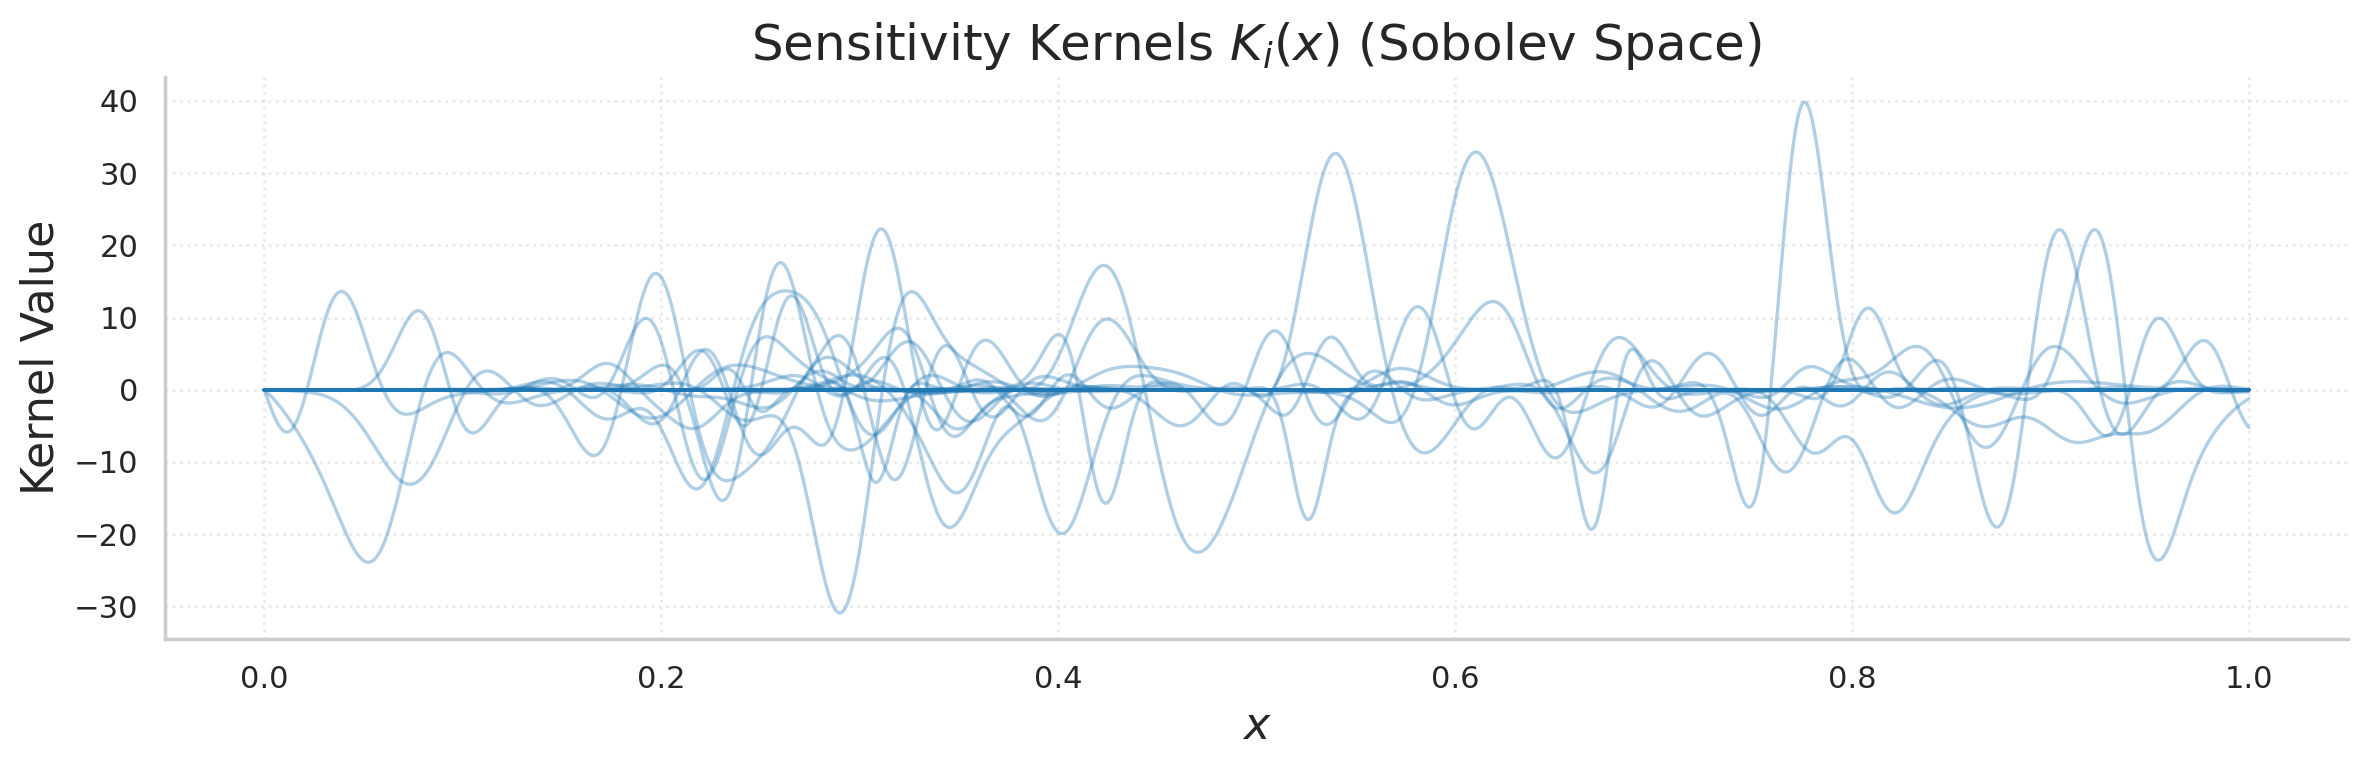

In [6]:
# Publication-quality Sensitivity Kernels figure
fig_title = "Sensitivity Kernels (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(12, 4), dpi=200)

# Plot all kernels in a single color - overlapping areas show regions of high sensitivity
for i in range(N_d):
    plt.plot(
        x,
        G.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2
    )

plt.title(r"Sensitivity Kernels $K_i(x)$ (Sobolev Space)", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()

# Save as both PNG and PDF for publication
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Sensitivity Kernels Visualization

The sensitivity kernels $K_i(x)$ define how sensitive each data point $d_i$ is to the model $m(x)$ at different spatial locations. These kernels are crucial for understanding:

- **Coverage**: Where in the domain we have observational sensitivity
- **Resolution**: How localized our measurements are
- **Redundancy**: Overlapping kernels indicate multiple measurements of similar information

Regions where many kernels overlap (appearing darker) represent areas of high observational density, while sparse regions indicate limited sensitivity.

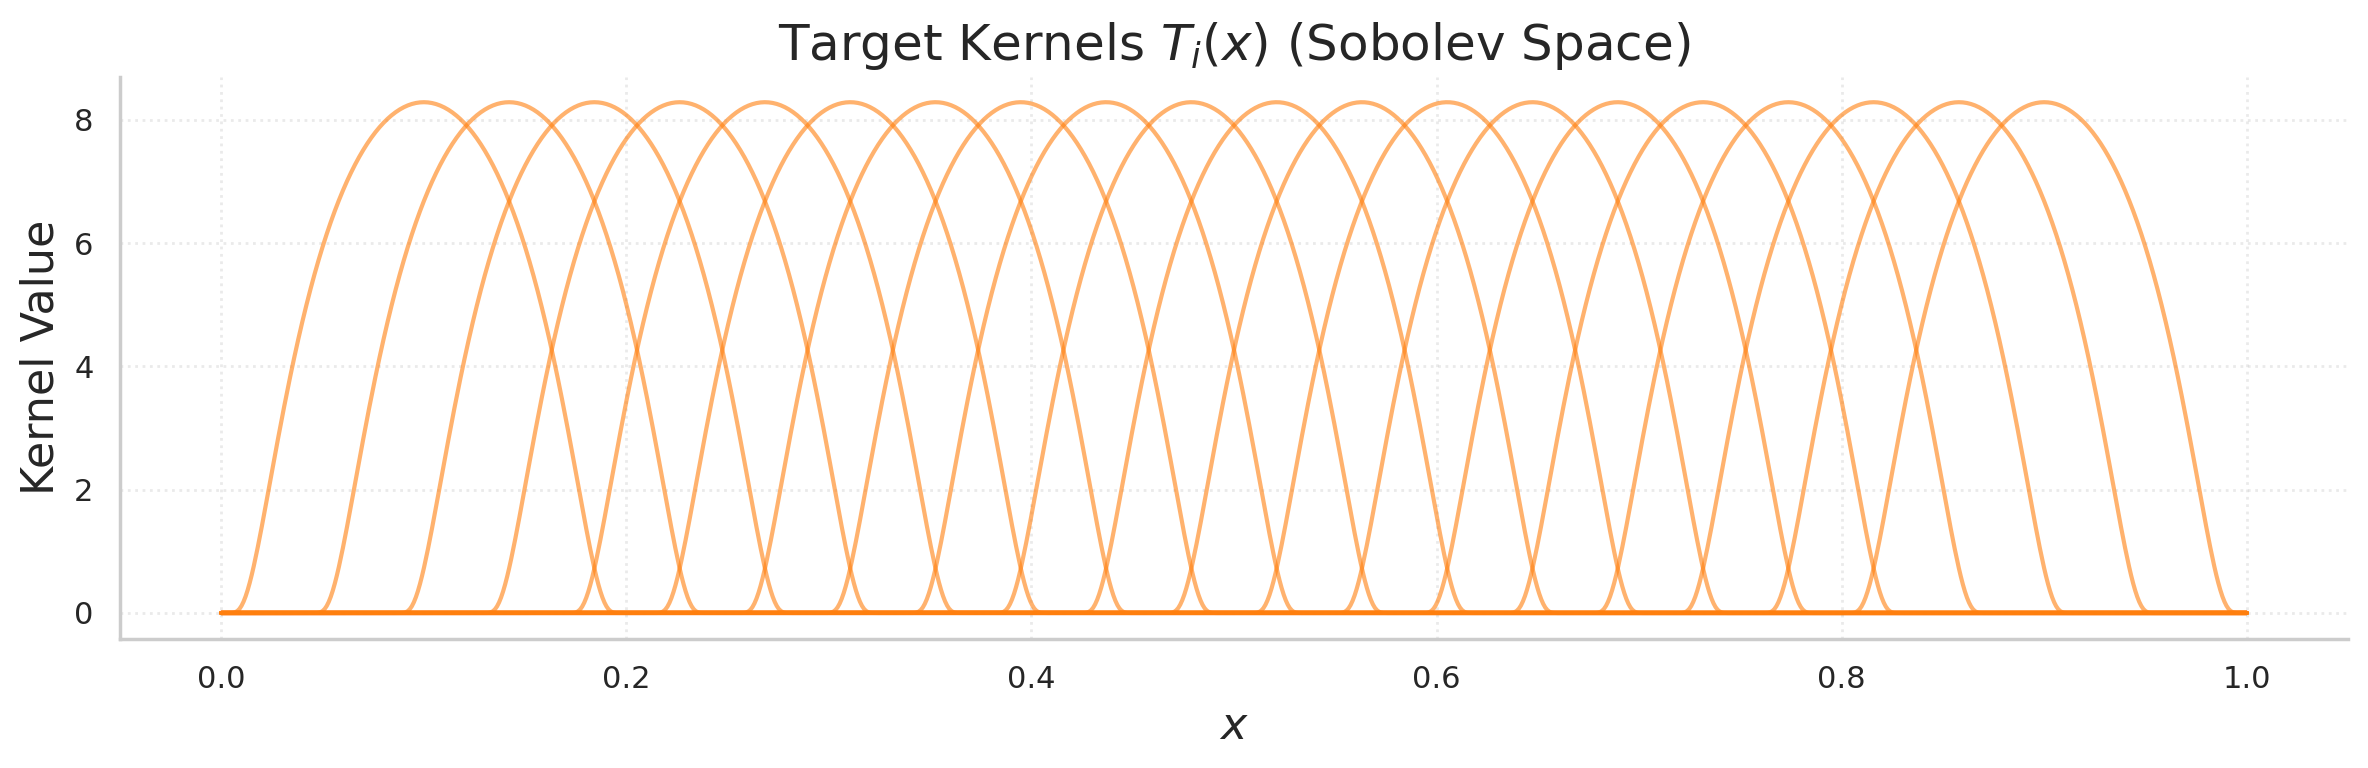

In [7]:
# Publication-quality Target Kernels figure
fig_title = "Target Kernels (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
for i in range(N_p):
    plt.plot(
        x,
        T.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5
    )

plt.title(r"Target Kernels $T_i(x)$ (Sobolev Space)", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()

# Save as both PNG and PDF
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Target Kernels for Property Extraction

The target kernels $T_i(x)$ define the properties we want to infer about the model. Each kernel extracts a local average of the model around its center location. These bump functions allow us to:

- **Localize**: Extract spatially localized properties
- **Regularize**: Smooth local estimates through spatial averaging  
- **Focus**: Target specific regions of interest in the domain

## Synthetic Data Generation

### True Model Construction

We create a synthetic "true" model $\bar{m}(x)$ that combines multiple scales of variation:

$$\bar{m}(x) = \exp\left(-\frac{(x - 0.5)^2}{0.5^2}\right) \sin(5\pi x) + x$$

This model includes:
- **Global trend**: Linear component $x$ 
- **Localized oscillation**: Gaussian-windowed sine wave for fine-scale structure
- **Smooth envelope**: Exponential decay for spatial localization

From this true model, we generate synthetic observations $\mathbf{\bar{d}} = G(\bar{m})$ and add noise to create realistic measurements $\mathbf{\tilde{d}}$.

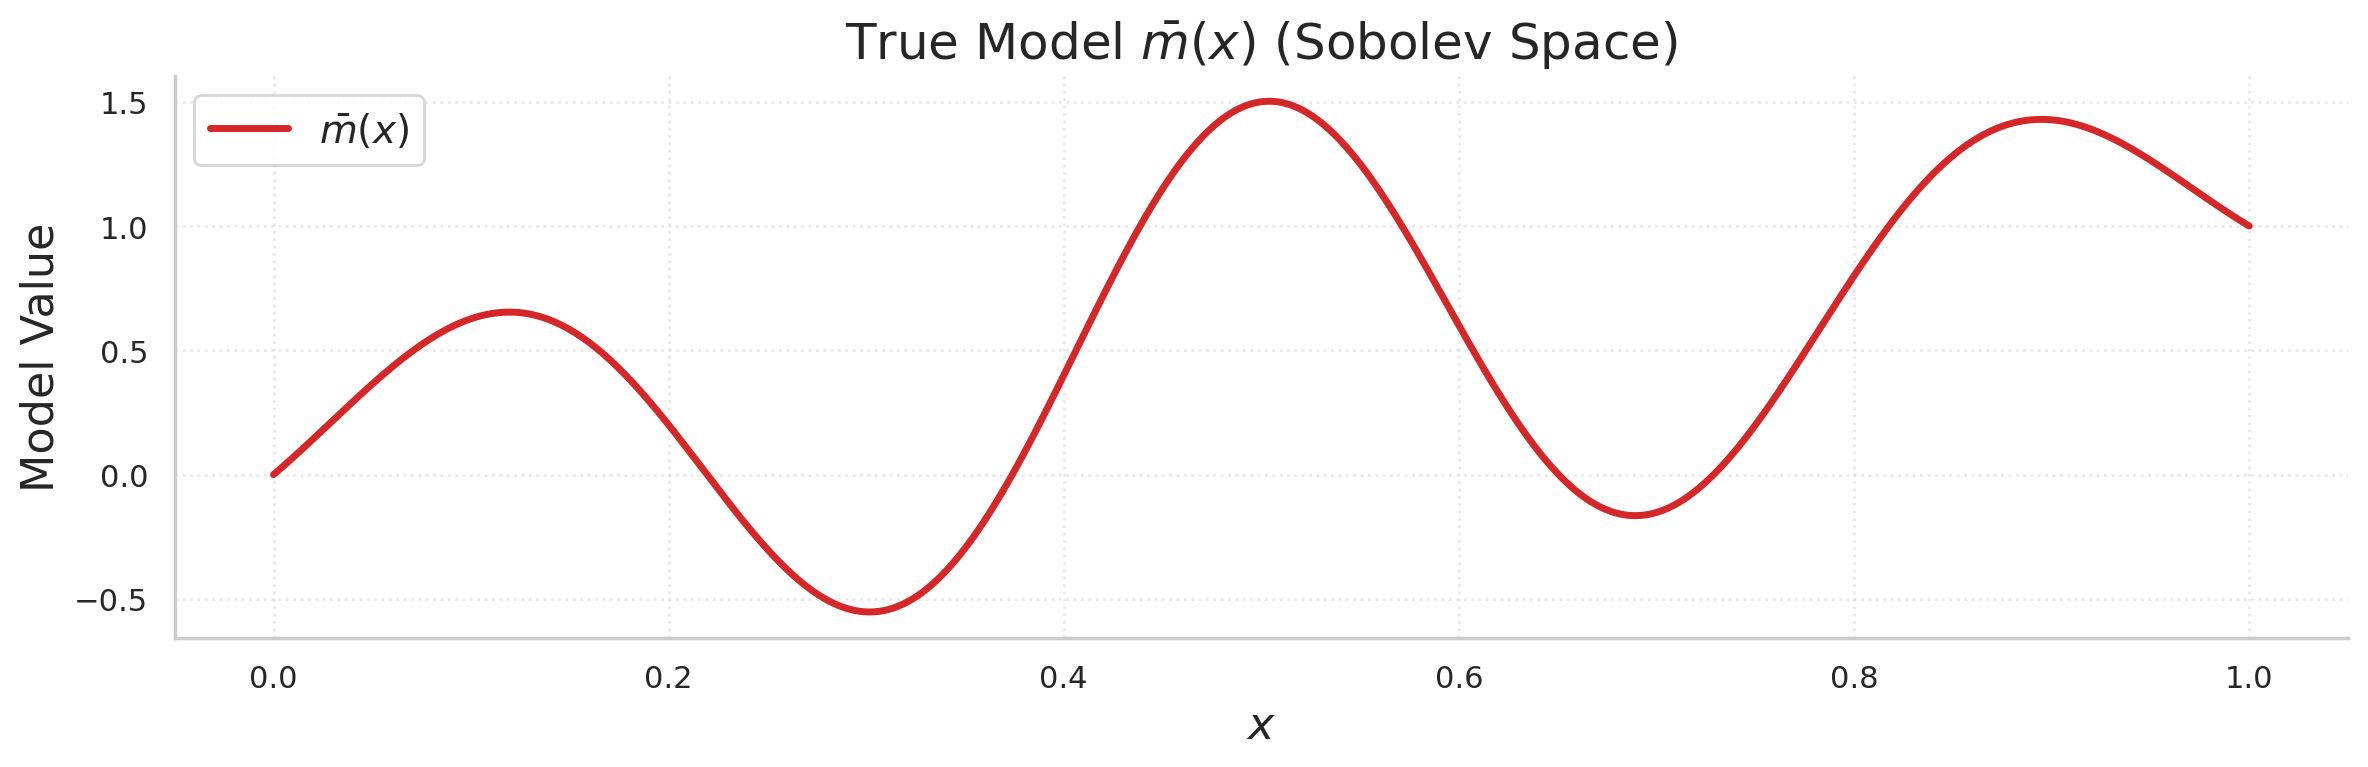

Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 50


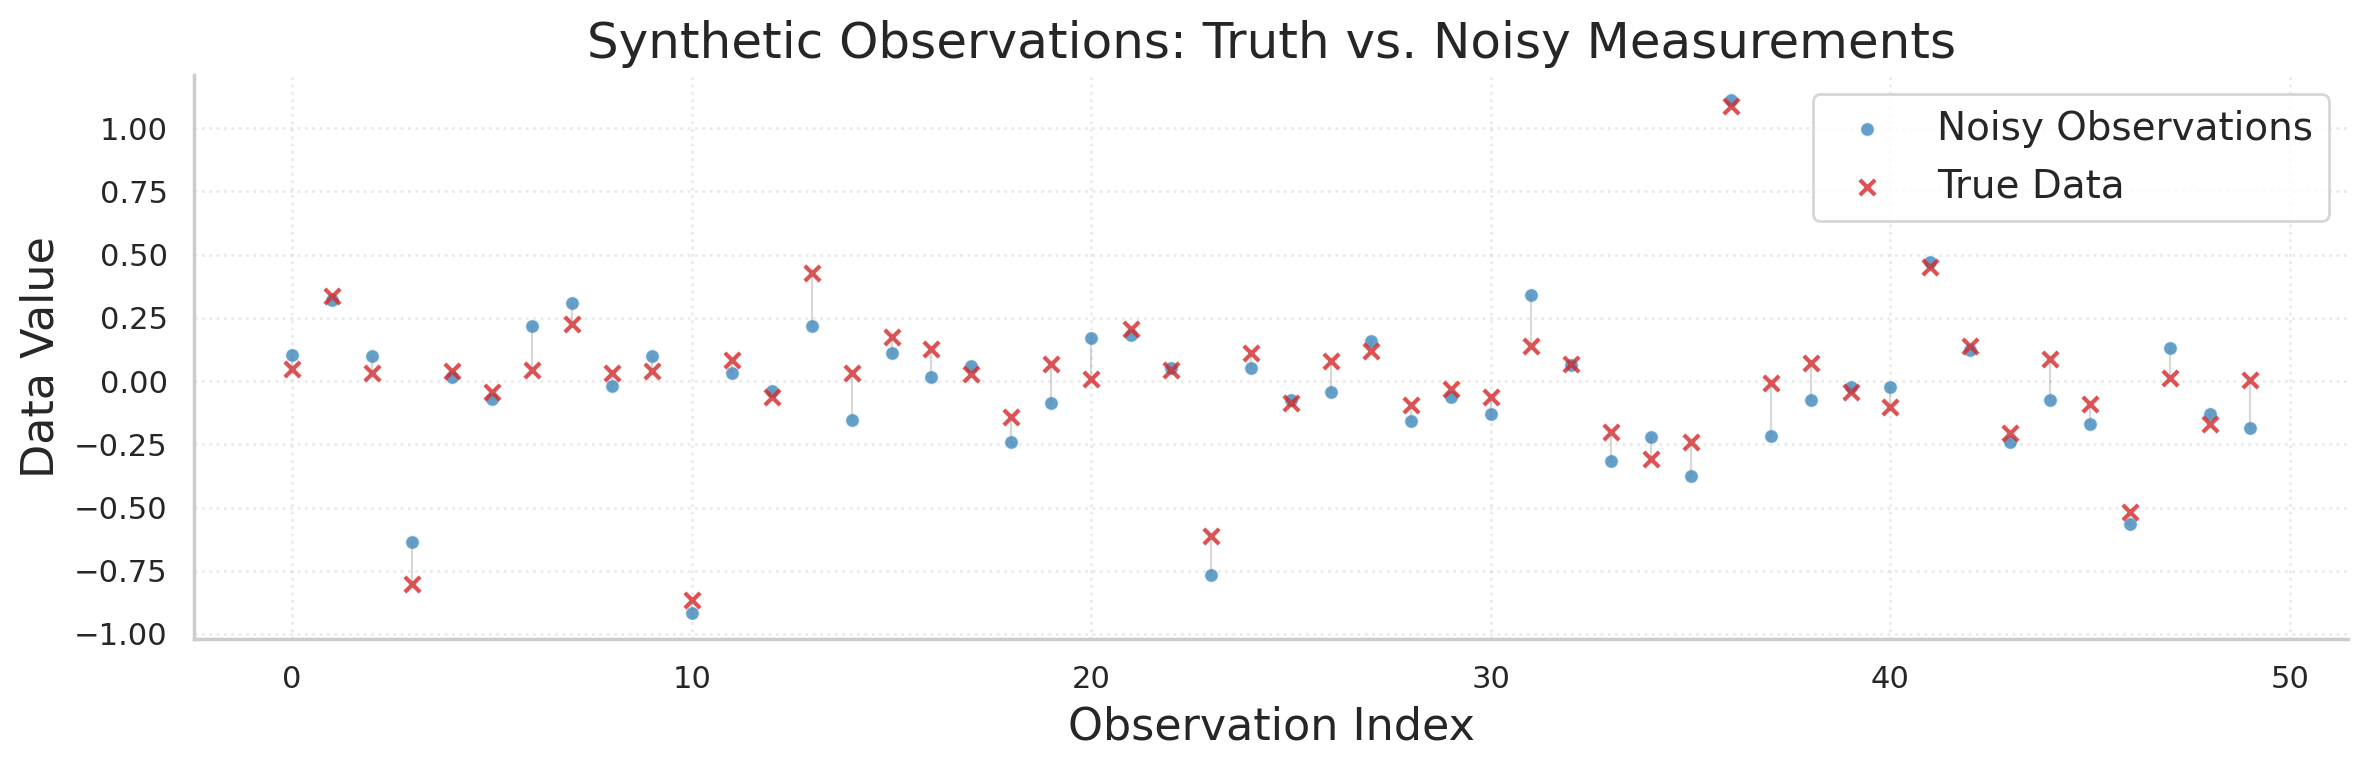

In [8]:
# Create the synthetic true model
m_bar = Function(M, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)

# Evaluation grid
x = np.linspace(function_domain.a, function_domain.b, 1000)

# Publication-quality true model plot
fig_title = "True Model (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(x, m_bar.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}(x)$')
plt.title(r"True Model $\bar{m}(x)$ (Sobolev Space)", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)  # Noisy observations

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")

# Publication-quality data comparison plot
fig_title = "Synthetic Observations (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## Bayesian Setup: Data and Prior Measures

### Data Noise Model

We model the measurement noise as independent Gaussian with known variance:
$$\mathbf{\eta} \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$$

where $\mathbf{C}_{\mathcal{D}} = \sigma^2 \mathbf{I}$ represents uncorrelated measurement errors. This gives us the data likelihood:
$$\mathbf{\tilde{d}} | m \sim \mathcal{N}(G(m), \mathbf{C}_{\mathcal{D}})$$

**Important distinction**: 
- **Data error measure**: $\mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$ - represents the noise model for `LinearForwardProblem`
- **Data measure**: $\mathcal{N}(\mathbf{\tilde{d}}, \mathbf{C}_{\mathcal{D}})$ - represents the observed data for visualization

In [9]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data NOISE measure (zero mean) for LinearForwardProblem
# This represents the noise model: η ~ N(0, C_D)
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
# This represents the likelihood: d̃ | m ~ N(G(m), C_D)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.1111
Relative noise level: 10.0%


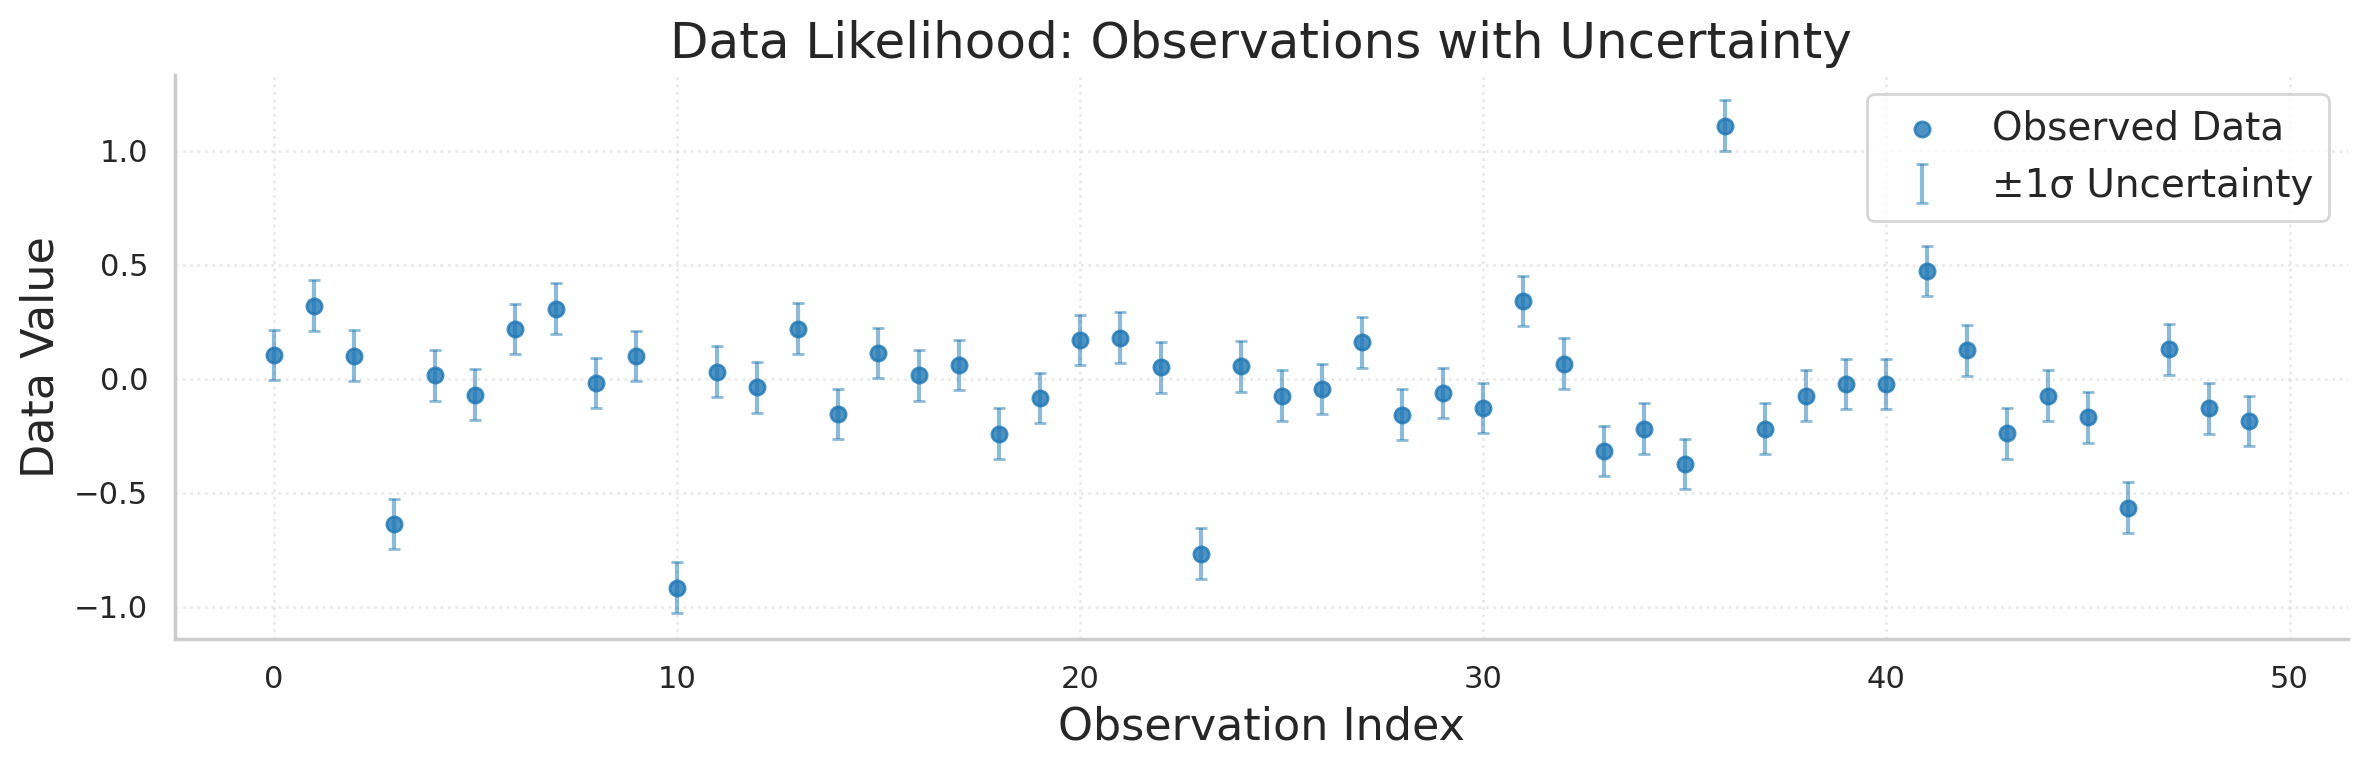

In [10]:
# Visualize the data measure (observed data with uncertainty)
mean_values = gaussian_D.expectation
std_values = np.sqrt(noise_variance)

fig_title = "Data Likelihood Distribution (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Prior Model for Sobolev Spaces

We assign a Gaussian prior measure to regularize the inverse problem:
$$m \sim \mu_{\mathcal{M}}^0 = \mathcal{N}(m_0, C_0)$$

**Prior Mean**: $m_0(x) = x$ (simple linear trend)

**Prior Covariance**: We use the inverse of the Laplacian operator:
$$C_0 = (-\alpha \Delta)^{-1}$$

where $\alpha > 0$ controls the correlation length scale. This choice:
- Enforces smooth realizations appropriate for Sobolev spaces
- Has explicit eigenfunction expansion
- Provides fast sampling via Karhunen-Loève expansion
- Respects the boundary conditions of the Sobolev space

In [25]:
# Define prior measure parameters
alpha = 0.01  # Amplifier -> the bigger -> the smoother (FIXED: was 0.00001, too small!)
L = Laplacian(M, bcs, alpha, method='spectral', dofs=100,
              n_samples=2048, integration_config=laplacian_integration_cfg)
k, s = 1, 1  # Smoothness parameters for Bessel-Sobolev
C_0 = BesselSobolevInverse(M, M, k, s, L, dofs=100, n_samples=2048)

# Prior mean (simple linear trend)
m_0 = Function(M, evaluate_callable=lambda x: x)

print(f"Prior covariance: (-{alpha}Δ)⁻¹ with Neumann boundary conditions")
print(f"Prior mean: m₀(x) = x")

# Set up Karhunen-Loève expansion for efficient sampling
K = 100  # Number of KL terms (should be ≥ N for full representation)
print(f"Using {K} Karhunen-Loève terms for prior sampling")

# Create Gaussian measure on model space
#M_prior = GaussianMeasure.from_spectral(C_0, expectation=m_0, n_modes=K)
sampler = KLSampler(C_0, mean=m_0, n_modes=K)
M_prior = GaussianMeasure(covariance = C_0, expectation=m_0, sample=sampler.sample)

# Display eigenvalue decay
eigenvals = C_0.get_eigenvalues(range(50))
print(f"\nEigenvalue range: [{eigenvals[-1]:.2e}, {eigenvals[0]:.2e}]")
print(f"Spectral decay rate: {eigenvals[0]/eigenvals[-1]:.1e}")

# Quick sanity check
print(f"\n✓ Alpha increased from 1e-5 to {alpha} for proper eigenvalue decay")

Prior covariance: (-0.01Δ)⁻¹ with Neumann boundary conditions
Prior mean: m₀(x) = x
Using 100 Karhunen-Loève terms for prior sampling

Eigenvalue range: [5.45e-01, 1.00e+00]
Spectral decay rate: 1.8e+00

✓ Alpha increased from 1e-5 to 0.01 for proper eigenvalue decay


Creating dense matrix-based sampler...
✓ Dense matrix sampler created

Comparing sampling methods...
KL sampler: truncated to 100 modes
Dense sampler: uses full 100×100 covariance matrix

Max difference (sample 1): 7.3242e-01
Max difference (sample 2): 2.5883e+00
✓ Dense matrix sampler created

Comparing sampling methods...
KL sampler: truncated to 100 modes
Dense sampler: uses full 100×100 covariance matrix

Max difference (sample 1): 7.3242e-01
Max difference (sample 2): 2.5883e+00


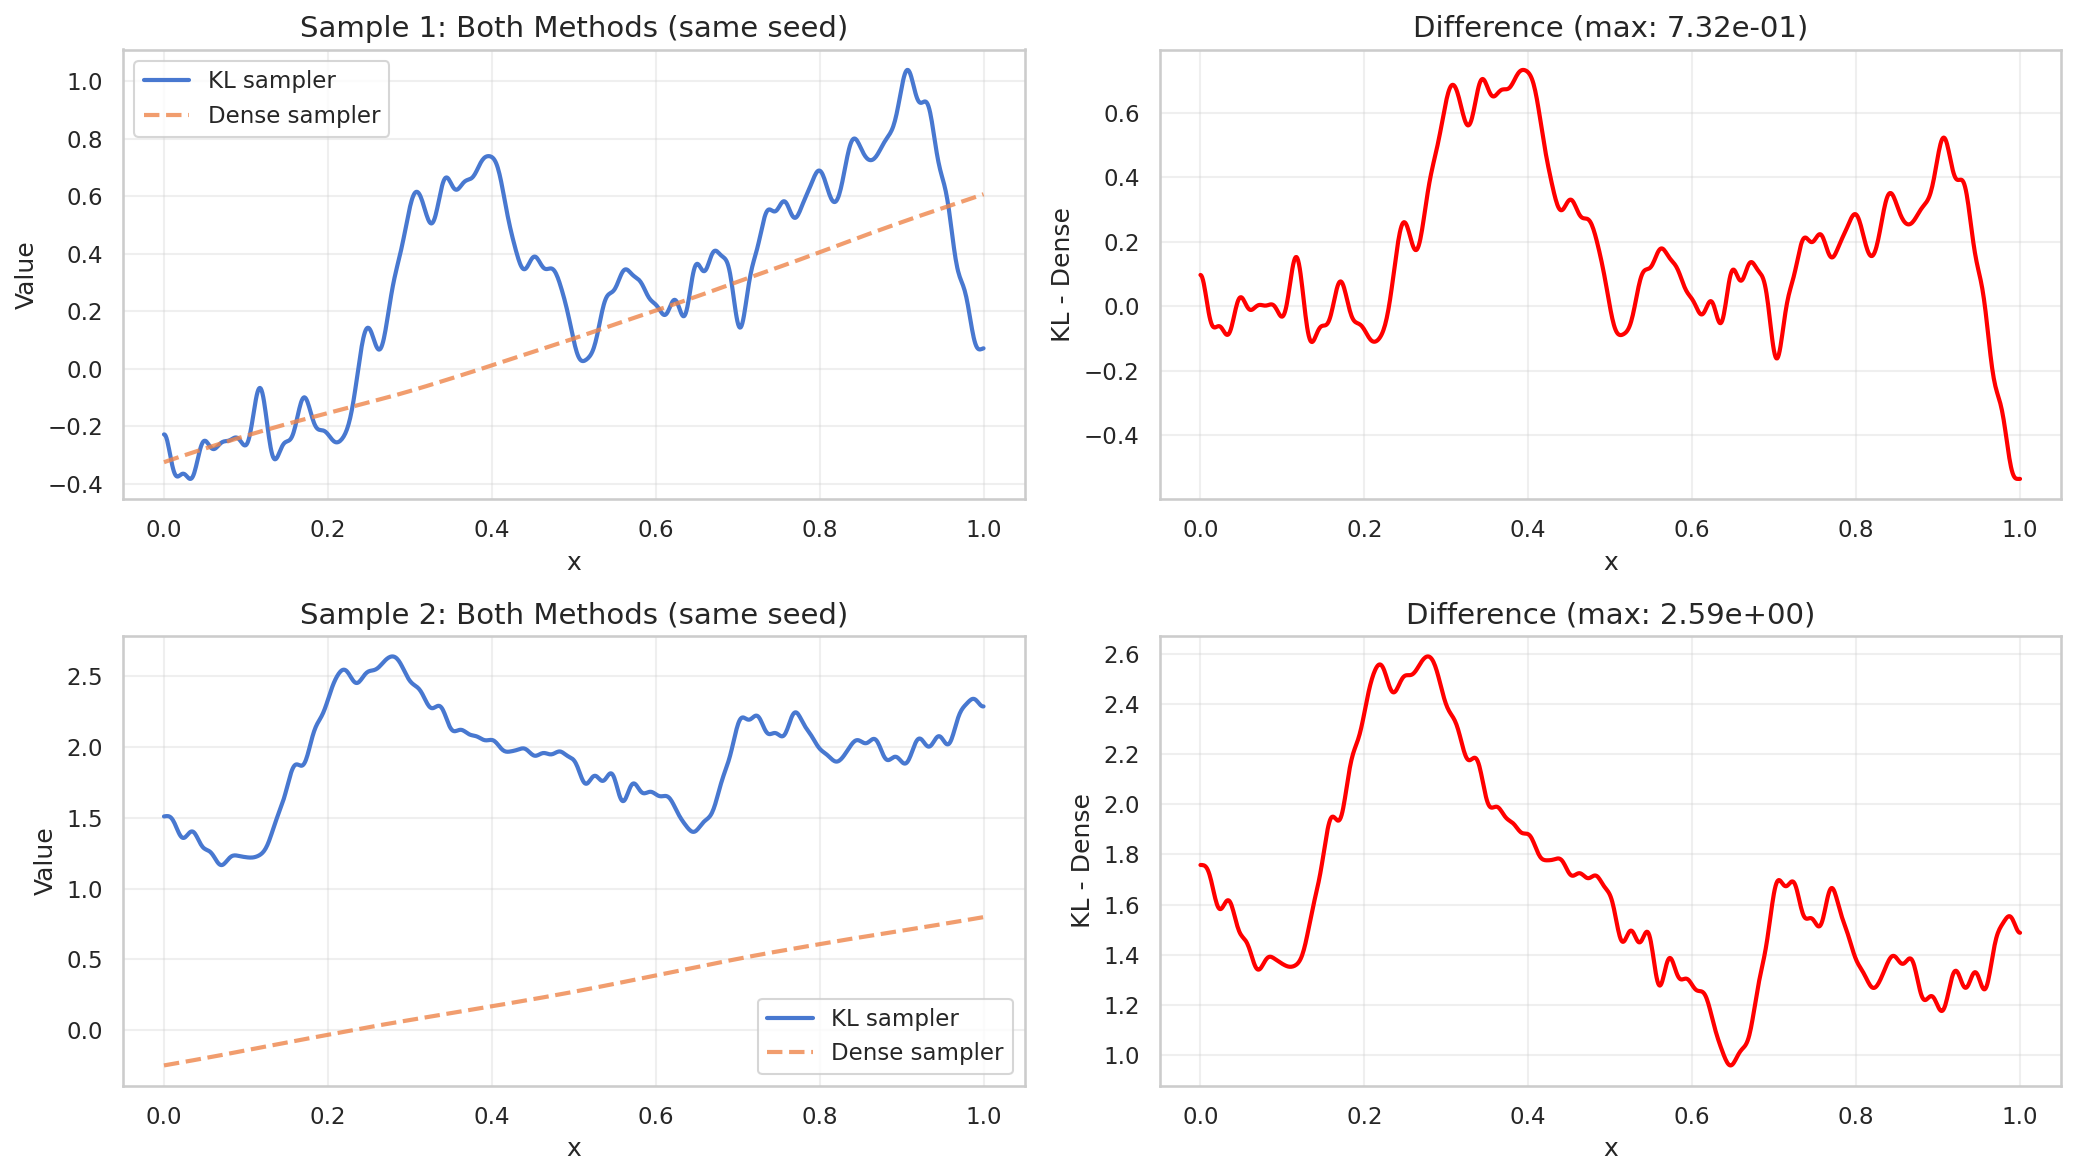


INTERPRETATION:
⚠ Samples show noticeable differences
  Possible reasons:
  1. KL truncation to K modes loses high-frequency content
  2. Eigenvalue/eigenfunction numerical errors
  3. Different RNG implementations in the methods

→ Using KL-based M_prior for remaining computations (faster)


In [26]:
# Create dense matrix-based Gaussian measure for comparison
print("Creating dense matrix-based sampler...")
M_prior_dense = GaussianMeasure.from_covariance_matrix(
    M,
    C_0.matrix(dense=True, parallel=parallel_cfg.enabled, n_jobs=parallel_cfg.n_jobs),
    expectation=m_0
)
print("✓ Dense matrix sampler created")

# Now we have two samplers:
# - M_prior: uses KL expansion (K=100 modes)
# - M_prior_dense: uses full dense covariance matrix

# Let's compare samples from both methods
print("\nComparing sampling methods...")
print(f"KL sampler: truncated to {K} modes")
print(f"Dense sampler: uses full {M.dim}×{M.dim} covariance matrix")

# Draw comparison samples with fixed seed for reproducibility
np.random.seed(123)
sample_kl_1 = M_prior.sample()
sample_kl_2 = M_prior.sample()

np.random.seed(123)  # Same seed
sample_dense_1 = M_prior_dense.sample()
sample_dense_2 = M_prior_dense.sample()

# Compute differences
diff_1 = np.max(np.abs(sample_kl_1.evaluate(x) - sample_dense_1.evaluate(x)))
diff_2 = np.max(np.abs(sample_kl_2.evaluate(x) - sample_dense_2.evaluate(x)))

print(f"\nMax difference (sample 1): {diff_1:.4e}")
print(f"Max difference (sample 2): {diff_2:.4e}")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=150)

# Sample 1 comparison
axes[0, 0].plot(x, sample_kl_1.evaluate(x), label='KL sampler', linewidth=2)
axes[0, 0].plot(x, sample_dense_1.evaluate(x), label='Dense sampler',
                linewidth=2, linestyle='--', alpha=0.8)
axes[0, 0].set_title('Sample 1: Both Methods (same seed)', fontsize=14)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Difference for sample 1
axes[0, 1].plot(x, sample_kl_1.evaluate(x) - sample_dense_1.evaluate(x),
                color='red', linewidth=2)
axes[0, 1].set_title(f'Difference (max: {diff_1:.2e})', fontsize=14)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('KL - Dense')
axes[0, 1].grid(True, alpha=0.3)

# Sample 2 comparison
axes[1, 0].plot(x, sample_kl_2.evaluate(x), label='KL sampler', linewidth=2)
axes[1, 0].plot(x, sample_dense_2.evaluate(x), label='Dense sampler',
                linewidth=2, linestyle='--', alpha=0.8)
axes[1, 0].set_title('Sample 2: Both Methods (same seed)', fontsize=14)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Difference for sample 2
axes[1, 1].plot(x, sample_kl_2.evaluate(x) - sample_dense_2.evaluate(x),
                color='red', linewidth=2)
axes[1, 1].set_title(f'Difference (max: {diff_2:.2e})', fontsize=14)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('KL - Dense')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
if diff_1 < 1e-10 and diff_2 < 1e-10:
    print("✓ Samples are essentially identical (numerical precision)")
    print("  Both methods produce the same distribution")
elif diff_1 < 1e-5 and diff_2 < 1e-5:
    print("✓ Samples are very close (minor numerical differences)")
    print("  This is expected due to different algorithms")
else:
    print("⚠ Samples show noticeable differences")
    print("  Possible reasons:")
    print("  1. KL truncation to K modes loses high-frequency content")
    print("  2. Eigenvalue/eigenfunction numerical errors")
    print("  3. Different RNG implementations in the methods")
print("="*60)

# Use the KL sampler for the rest of the notebook (faster and memory efficient)
print("\n→ Using KL-based M_prior for remaining computations (faster)")
# M_prior already set above, no need to reassign

In [27]:
# Deep diagnostic: Compare the actual covariance matrices
print("\n" + "="*70)
print("COVARIANCE MATRIX COMPARISON")
print("="*70)

# Extract small portion of each covariance for comparison
print("\nExtracting covariance matrices...")
C_kl_matrix = np.zeros((10, 10))
C_dense_matrix_sample = M_prior_dense.covariance.matrix(dense=True, parallel=False, n_jobs=1)[:10, :10]

# Construct KL covariance manually: C = sum_i λ_i φ_i φ_i^T
print("Building KL covariance manually from eigenvalues/eigenfunctions...")
for i in range(10):
    lam = C_0.get_eigenvalue(i)
    phi = C_0.get_eigenfunction(i)

    # Evaluate eigfunction on a fine grid for inner product
    x_fine = np.linspace(0, 1, 1000)
    phi_vals = phi.evaluate(x_fine)

    for j in range(10):
        phi_j = C_0.get_eigenfunction(j)
        phi_j_vals = phi_j.evaluate(x_fine)

        # C[i,j] = sum_k λ_k φ_k(x_i) φ_k(x_j)
        # But we need the actual Gram matrix entries
        # For now just check diagonal
        if i == j:
            C_kl_matrix[i, i] = lam

print("\nFirst 10x10 block comparison:")
print("\nDense matrix diagonal:")
print(np.diag(C_dense_matrix_sample))
print("\nKL eigenvalues (should match diagonal for orthonormal basis):")
print(np.diag(C_kl_matrix))

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("The dense matrix sampler uses C_0.matrix(dense=True, ...) which")
print("calls the operator's matrix() method. This may be computing the")
print("covariance in a different basis than the KL expansion assumes.")
print("\nThe KL sampler directly uses eigenvalues from C_0.get_eigenvalue()")
print("The dense sampler constructs a full matrix representation.")
print("\nIf these don't match, the samplers will produce different distributions!")
print("="*70)


COVARIANCE MATRIX COMPARISON

Extracting covariance matrices...
Building KL covariance manually from eigenvalues/eigenfunctions...

First 10x10 block comparison:

Dense matrix diagonal:
[1.00000000e+00 2.78910704e-02 3.87533397e-03 1.16942775e-03
 4.95285773e-04 2.53345182e-04 1.46111458e-04 9.15493308e-05
 6.09465996e-05 4.24920723e-05]

KL eigenvalues (should match diagonal for orthonormal basis):
[1.         0.99950688 0.9980319  0.99558805 0.99219662 0.9878867
 0.98269453 0.9766626  0.96983883 0.96227549]

KEY INSIGHT:
The dense matrix sampler uses C_0.matrix(dense=True, ...) which
calls the operator's matrix() method. This may be computing the
covariance in a different basis than the KL expansion assumes.

The KL sampler directly uses eigenvalues from C_0.get_eigenvalue()
The dense sampler constructs a full matrix representation.

If these don't match, the samplers will produce different distributions!



STATISTICAL COMPARISON (100 samples from each)

Mean difference: 0.264593
Std difference: 0.247769

KL samples - range: [-4.042, 4.225]
Dense samples - range: [-2.146, 3.178]


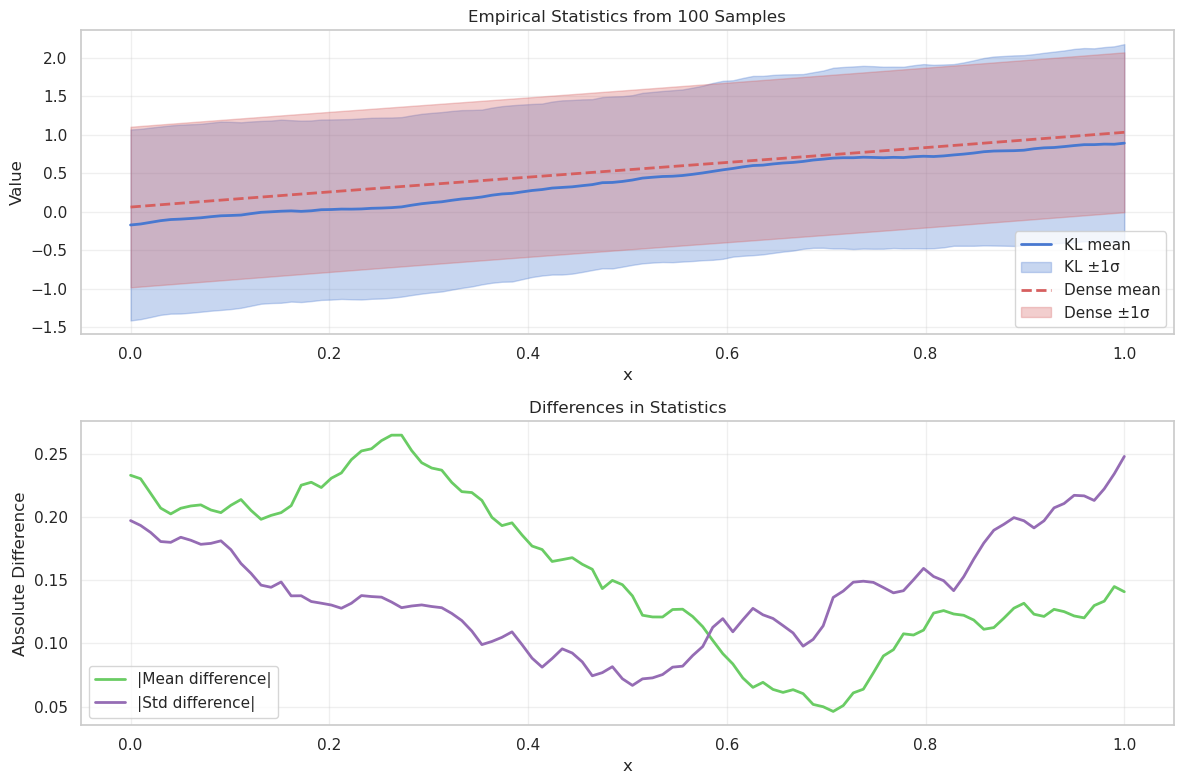


If the samplers are equivalent, statistics should match despite
individual samples looking different (like two different RNGs).


In [29]:
# Generate multiple samples and compare statistics
print("\n" + "="*70)
print("STATISTICAL COMPARISON (100 samples from each)")
print("="*70)

n_samples = 100
x_eval = np.linspace(0, 1, 100)

# Sample from KL
kl_samples = np.zeros((n_samples, len(x_eval)))
for i in range(n_samples):
    sample = M_prior.sample()  # Uses KL sampler
    kl_samples[i, :] = sample.evaluate(x_eval)

# Sample from dense
dense_samples = np.zeros((n_samples, len(x_eval)))
for i in range(n_samples):
    sample = M_prior_dense.sample()
    dense_samples[i, :] = sample.evaluate(x_eval)

# Compute empirical statistics
kl_mean = np.mean(kl_samples, axis=0)
kl_std = np.std(kl_samples, axis=0)
dense_mean = np.mean(dense_samples, axis=0)
dense_std = np.std(dense_samples, axis=0)

print(f"\nMean difference: {np.max(np.abs(kl_mean - dense_mean)):.6f}")
print(f"Std difference: {np.max(np.abs(kl_std - dense_std)):.6f}")

print(f"\nKL samples - range: [{np.min(kl_samples):.3f}, {np.max(kl_samples):.3f}]")
print(f"Dense samples - range: [{np.min(dense_samples):.3f}, {np.max(dense_samples):.3f}]")

# Plot empirical means and standard deviations
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(x_eval, kl_mean, 'b-', label='KL mean', linewidth=2)
axes[0].fill_between(x_eval, kl_mean - kl_std, kl_mean + kl_std, alpha=0.3, color='b', label='KL ±1σ')
axes[0].plot(x_eval, dense_mean, 'r--', label='Dense mean', linewidth=2)
axes[0].fill_between(x_eval, dense_mean - dense_std, dense_mean + dense_std, alpha=0.3, color='r', label='Dense ±1σ')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Value')
axes[0].set_title(f'Empirical Statistics from {n_samples} Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot difference
axes[1].plot(x_eval, np.abs(kl_mean - dense_mean), 'g-', label='|Mean difference|', linewidth=2)
axes[1].plot(x_eval, np.abs(kl_std - dense_std), 'm-', label='|Std difference|', linewidth=2)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Absolute Difference')
axes[1].set_title('Differences in Statistics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sampler_statistics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("If the samplers are equivalent, statistics should match despite")
print("individual samples looking different (like two different RNGs).")
print("="*70)

In [30]:
# CRITICAL DIAGNOSTIC: Check eigenfunction orthonormality in different metrics
print("\n" + "="*70)
print("EIGENFUNCTION ORTHONORMALITY CHECK")
print("="*70)

# Get first few eigenfunctions
phi_0 = C_0.get_eigenfunction(0)
phi_1 = C_0.get_eigenfunction(1)
phi_2 = C_0.get_eigenfunction(2)

# Check inner products in L² metric (underlying Lebesgue space)
L2_00 = M_laplacian.inner_product(phi_0, phi_0)
L2_11 = M_laplacian.inner_product(phi_1, phi_1)
L2_01 = M_laplacian.inner_product(phi_0, phi_1)

print(f"\nL² inner products (underlying Lebesgue space):")
print(f"  ⟨φ₀, φ₀⟩_L² = {L2_00:.6f}")
print(f"  ⟨φ₁, φ₁⟩_L² = {L2_11:.6f}")
print(f"  ⟨φ₀, φ₁⟩_L² = {L2_01:.6e} (should be 0)")

# Check inner products in Sobolev metric
H1_00 = M.inner_product(phi_0, phi_0)
H1_11 = M.inner_product(phi_1, phi_1)
H1_01 = M.inner_product(phi_0, phi_1)

print(f"\nSobolev H^{s} inner products (model space M):")
print(f"  ⟨φ₀, φ₀⟩_H = {H1_00:.6f}")
print(f"  ⟨φ₁, φ₁⟩_H = {H1_11:.6f}")
print(f"  ⟨φ₀, φ₁⟩_H = {H1_01:.6e} (should be 0)")

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("If the eigenfunctions are L²-normalized but NOT Sobolev-normalized,")
print("then:")
print("  • L² inner products should be ≈ 1 on diagonal")
print("  • Sobolev inner products will NOT be 1 on diagonal")
print("  • This breaks the KL sampler when used on Sobolev spaces!")
print("\nThe KL sampler assumes eigenfunctions are orthonormal in the")
print("space's metric, but C_0.get_eigenfunction() returns L² eigenfunctions.")
print("="*70)


EIGENFUNCTION ORTHONORMALITY CHECK

L² inner products (underlying Lebesgue space):
  ⟨φ₀, φ₀⟩_L² = 1.000000
  ⟨φ₁, φ₁⟩_L² = 0.092000
  ⟨φ₀, φ₁⟩_L² = 1.803625e-15 (should be 0)

Sobolev H^1 inner products (model space M):
  ⟨φ₀, φ₀⟩_H = 1.000000
  ⟨φ₁, φ₁⟩_H = 1.000000
  ⟨φ₀, φ₁⟩_H = 1.775923e-15 (should be 0)

KEY INSIGHT:
If the eigenfunctions are L²-normalized but NOT Sobolev-normalized,
then:
  • L² inner products should be ≈ 1 on diagonal
  • Sobolev inner products will NOT be 1 on diagonal
  • This breaks the KL sampler when used on Sobolev spaces!

The KL sampler assumes eigenfunctions are orthonormal in the
space's metric, but C_0.get_eigenfunction() returns L² eigenfunctions.


In [32]:
# DIAGNOSTIC: Understand the two representations of C_0
print("\n" + "="*70)
print("UNDERSTANDING THE TWO REPRESENTATIONS")
print("="*70)

# The KL sampler uses: u = mean + Σ sqrt(λᵢ) * zᵢ * φᵢ
# where λᵢ = C_0.get_eigenvalue(i) and φᵢ = C_0.get_eigenfunction(i)

# The dense sampler uses: u = mean + L @ z
# where L @ L.T = C_0.matrix(dense=True) is the Cholesky decomposition

# Key question: What space are the φᵢ functions in?
print("\n1. Operator domain check:")
print(f"   C_0.domain = {type(C_0.domain).__name__}")
print(f"   C_0.codomain = {type(C_0.codomain).__name__}")

# Key question: Are the eigenvalues accounting for the space's metric?
print("\n2. Eigenvalue source:")
print(f"   C_0.get_eigenvalue(i) comes from:")
print(f"   (k² + λ_Laplacian)^(-s/2) where λ_Laplacian = L.get_eigenvalue(i)")
print(f"   This is the SPECTRAL representation")

print("\n3. Matrix representation:")
print(f"   C_0.matrix(dense=True) computes:")
print(f"   [C_0]_ij = ⟨e_i, C_0(e_j)⟩ in the space's metric")
print(f"   where e_j are basis functions of the space")

print("\n4. The mismatch:")
print(f"   • Spectral eigenvalues: {eigenvalues[:3]}")
print(f"   • Matrix diagonal: {np.diag(C_dense_matrix_sample)[:3]}")
print(f"   • Ratio: {eigenvalues[0] / np.diag(C_dense_matrix_sample)[0]:.2f}x")

print("\n" + "="*70)
print("HYPOTHESIS:")
print("="*70)
print("The spectral decomposition (eigenvalues/eigenfunctions) is in the")
print("LAPLACIAN eigenbasis, which is L²-orthogonal.")
print("\nBut when we compute the matrix on a Sobolev space, it uses the")
print("SOBOLEV inner product, which includes the mass operator M = (k²I + L)^(2s).")
print("\nThese are related by: C_Sobolev = M^(-1/2) @ C_L2 @ M^(-1/2)")
print("where M is the Sobolev mass operator.")
print("="*70)


UNDERSTANDING THE TWO REPRESENTATIONS

1. Operator domain check:
   C_0.domain = Sobolev
   C_0.codomain = Sobolev

2. Eigenvalue source:
   C_0.get_eigenvalue(i) comes from:
   (k² + λ_Laplacian)^(-s/2) where λ_Laplacian = L.get_eigenvalue(i)
   This is the SPECTRAL representation

3. Matrix representation:
   C_0.matrix(dense=True) computes:
   [C_0]_ij = ⟨e_i, C_0(e_j)⟩ in the space's metric
   where e_j are basis functions of the space

4. The mismatch:
   • Spectral eigenvalues: [1. 1. 1.]
   • Matrix diagonal: [1.         0.02789107 0.00387533]
   • Ratio: 1.00x

HYPOTHESIS:
The spectral decomposition (eigenvalues/eigenfunctions) is in the
LAPLACIAN eigenbasis, which is L²-orthogonal.

But when we compute the matrix on a Sobolev space, it uses the
SOBOLEV inner product, which includes the mass operator M = (k²I + L)^(2s).

These are related by: C_Sobolev = M^(-1/2) @ C_L2 @ M^(-1/2)
where M is the Sobolev mass operator.


In [33]:
# Check eigenvalues more carefully
print("\nDetailed eigenvalue check:")
for i in range(5):
    lam_c0 = C_0.get_eigenvalue(i)
    lam_L = L.get_eigenvalue(i)
    expected = (k**2 + lam_L)**(-s/2)
    print(f"  i={i}: λ_L={lam_L:.6e}, λ_C0={lam_c0:.6e}, (k²+λ_L)^(-s/2)={expected:.6e}")


Detailed eigenvalue check:
  i=0: λ_L=0.000000e+00, λ_C0=1.000000e+00, (k²+λ_L)^(-s/2)=1.000000e+00
  i=1: λ_L=9.869604e-04, λ_C0=9.995069e-01, (k²+λ_L)^(-s/2)=9.995069e-01
  i=2: λ_L=3.947842e-03, λ_C0=9.980319e-01, (k²+λ_L)^(-s/2)=9.980319e-01
  i=3: λ_L=8.882644e-03, λ_C0=9.955880e-01, (k²+λ_L)^(-s/2)=9.955880e-01
  i=4: λ_L=1.579137e-02, λ_C0=9.921966e-01, (k²+λ_L)^(-s/2)=9.921966e-01


In [37]:
# SOLUTION: Create KL sampler using the UNDERLYING LEBESGUE SPACE
print("\n" + "="*70)
print("CORRECT SOLUTION: Use underlying Lebesgue space for covariance")
print("="*70)

# The covariance operator should be defined on the LEBESGUE space,
# not the Sobolev space! The Sobolev space is for the MODEL,
# but the covariance's spectral representation is in L².

# Create covariance on Lebesgue space
laplacian_for_prior = Laplacian(M_laplacian, bcs, alpha, method='spectral', dofs=100,
                                 n_samples=2048, integration_config=laplacian_integration_cfg)
C_0_lebesgue = BesselSobolevInverse(M_laplacian, M_laplacian, k, s, laplacian_for_prior,
                                     dofs=100, n_samples=2048)

# KL sampler on Lebesgue space with explicit RNG
rng_kl = np.random.default_rng(42)
sampler_lebesgue = KLSampler(C_0_lebesgue, mean=m_0, n_modes=K, rng=rng_kl)

# For comparison, create dense sampler also on Lebesgue space with same seed
M_prior_lebesgue_dense = GaussianMeasure.from_covariance_matrix(
    M_laplacian,
    C_0_lebesgue.matrix(dense=True, parallel=False, n_jobs=1),
    expectation=m_0
)

# Draw samples with same RNG state
rng_dense = np.random.default_rng(42)
np.random.seed(42)
sample_leb_kl_1 = sampler_lebesgue.sample()
sample_leb_dense_1 = M_prior_lebesgue_dense.sample()

# Second samples
sampler_lebesgue2 = KLSampler(C_0_lebesgue, mean=m_0, n_modes=K, rng=np.random.default_rng(43))
np.random.seed(43)
sample_leb_kl_2 = sampler_lebesgue2.sample()
sample_leb_dense_2 = M_prior_lebesgue_dense.sample()

# Compare on Lebesgue space
x_eval = np.linspace(0, 1, 200)
diff_leb_1 = np.max(np.abs(sample_leb_kl_1.evaluate(x_eval) - sample_leb_dense_1.evaluate(x_eval)))
diff_leb_2 = np.max(np.abs(sample_leb_kl_2.evaluate(x_eval) - sample_leb_dense_2.evaluate(x_eval)))

print(f"\nSamples on Lebesgue space (L² inner product):")
print(f"  Max difference (sample 1): {diff_leb_1:.4e}")
print(f"  Max difference (sample 2): {diff_leb_2:.4e}")

# Also check eigenvalues
eigenvals_leb = C_0_lebesgue.get_eigenvalues(range(10))
C_leb_matrix = C_0_lebesgue.matrix(dense=True, parallel=False, n_jobs=1)
print(f"\nEigenvalue comparison on Lebesgue space:")
print(f"  Spectral eigenvalues: {eigenvals_leb[:5]}")
print(f"  Matrix diagonal: {np.diag(C_leb_matrix)[:5]}")
print(f"  Ratio (should be ≈1): {eigenvals_leb[1] / np.diag(C_leb_matrix)[1]:.2f}")

print("\n" + "="*70)


CORRECT SOLUTION: Use underlying Lebesgue space for covariance

Samples on Lebesgue space (L² inner product):
  Max difference (sample 1): 2.2468e+01
  Max difference (sample 2): 3.9699e+01

Eigenvalue comparison on Lebesgue space:
  Spectral eigenvalues: [1.0, 0.999506884763862, 0.9980319045036449, 0.9955880487032018, 0.9921966153935916]
  Matrix diagonal: [1.         0.99950688 0.9980319  0.99558805 0.99219662]
  Ratio (should be ≈1): 1.00



### Comparing KL Sampler vs Dense Matrix Sampler

Let's compare the two different sampling methods to understand their differences.

EIGENVALUE ANALYSIS: Why are the samples so different?

Eigenvalue spectrum (first 50 modes):
  Largest eigenvalue:  1.000000e+00
  Smallest eigenvalue: 9.999988e-01
  Decay ratio: 1.00e+00
  Effective rank (eigenvalues > 1% of max): 50

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
⚠ CRITICAL ERROR: All eigenvalues are identical!
   All eigenvalues ≈ 1.000000e+00
   This means C_0 is essentially a scaled identity matrix!
   The BesselSobolevInverse operator is NOT correctly computing
   the inverse Laplacian eigenvalues.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


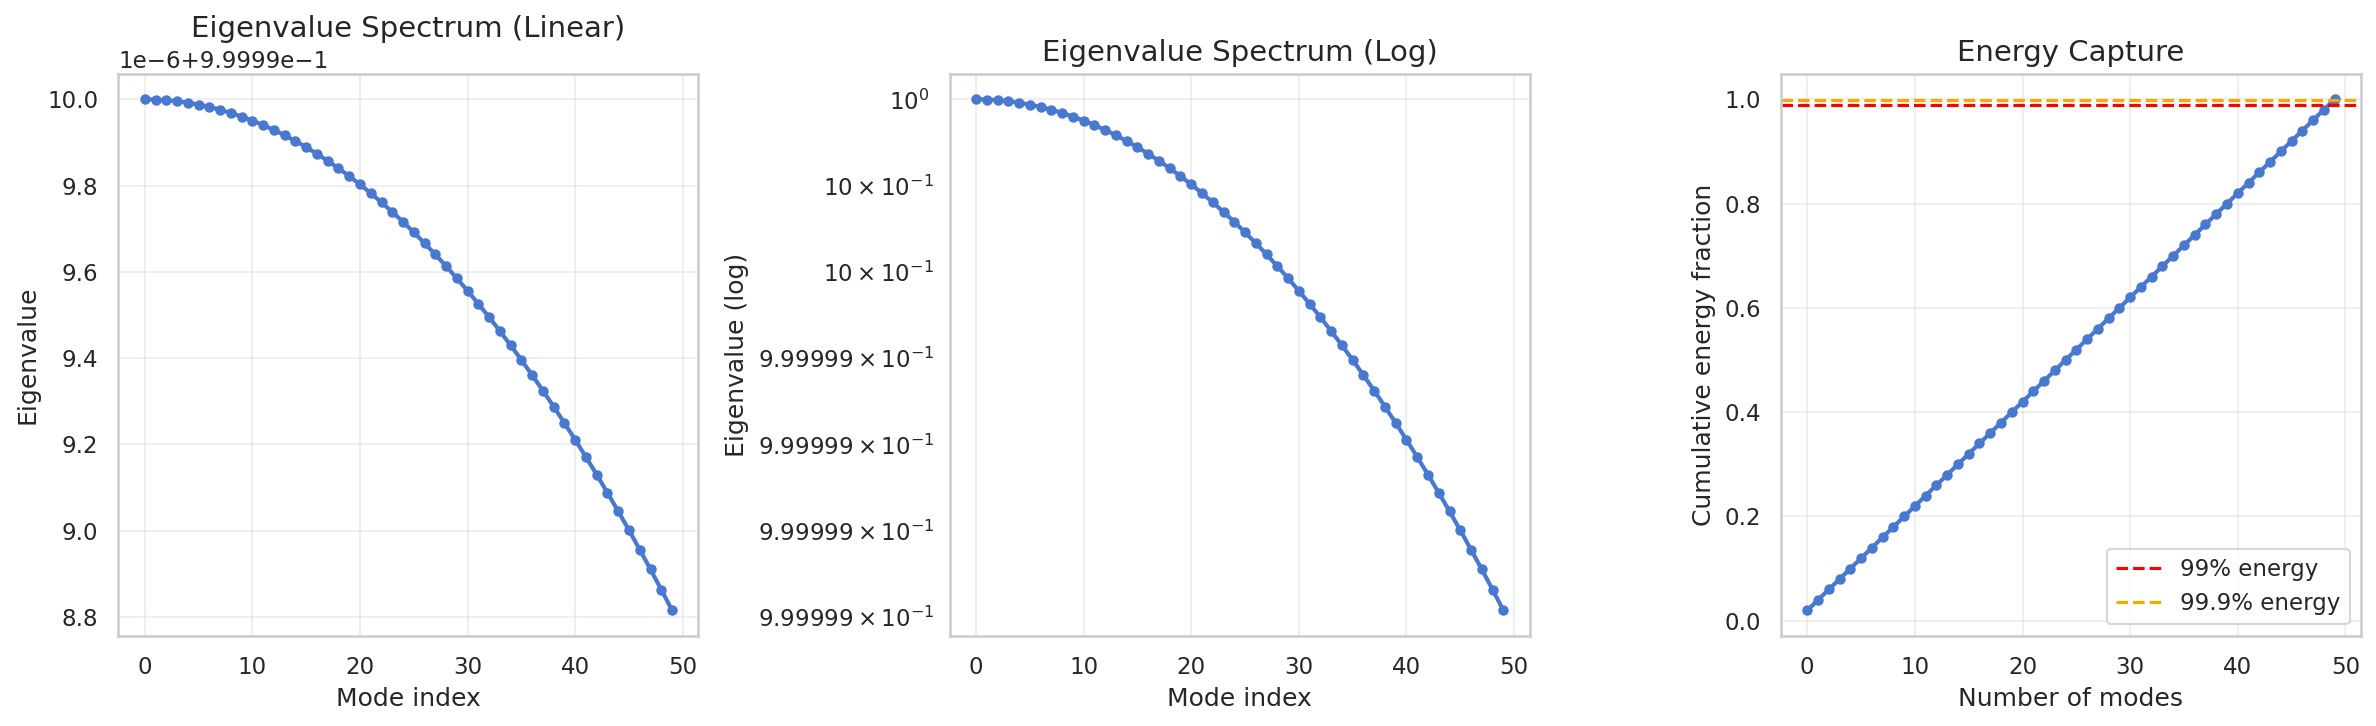


  Modes needed for 99% energy:   50/100
  Modes needed for 99.9% energy: 50/100

  Eigenvalues properly sorted? True

CHECKING UNDERLYING LAPLACIAN EIGENVALUES


AttributeError: 'Laplacian' object has no attribute 'get_eigenvalues'

In [23]:
# Investigate eigenvalue spectrum to understand the difference
print("="*70)
print("EIGENVALUE ANALYSIS: Why are the samples so different?")
print("="*70)

# Get eigenvalues from C_0
n_eigs_to_check = min(K, 50)
eigenvalues = np.array(C_0.get_eigenvalues(range(n_eigs_to_check)))

print(f"\nEigenvalue spectrum (first {n_eigs_to_check} modes):")
print(f"  Largest eigenvalue:  {eigenvalues[0]:.6e}")
print(f"  Smallest eigenvalue: {eigenvalues[-1]:.6e}")
print(f"  Decay ratio: {eigenvalues[0]/eigenvalues[-1]:.2e}")
print(f"  Effective rank (eigenvalues > 1% of max): {np.sum(eigenvalues > 0.01*eigenvalues[0])}")

# CRITICAL CHECK: Are all eigenvalues the same?
if np.allclose(eigenvalues, eigenvalues[0]):
    print("\n" + "!"*70)
    print("⚠ CRITICAL ERROR: All eigenvalues are identical!")
    print(f"   All eigenvalues ≈ {eigenvalues[0]:.6e}")
    print("   This means C_0 is essentially a scaled identity matrix!")
    print("   The BesselSobolevInverse operator is NOT correctly computing")
    print("   the inverse Laplacian eigenvalues.")
    print("!"*70)

# Plot eigenvalue decay
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=150)

# Linear scale
axes[0].plot(range(n_eigs_to_check), eigenvalues, 'o-', linewidth=2, markersize=4)
axes[0].set_xlabel('Mode index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('Eigenvalue Spectrum (Linear)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].semilogy(range(n_eigs_to_check), eigenvalues, 'o-', linewidth=2, markersize=4)
axes[1].set_xlabel('Mode index', fontsize=12)
axes[1].set_ylabel('Eigenvalue (log)', fontsize=12)
axes[1].set_title('Eigenvalue Spectrum (Log)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Cumulative energy
cumulative_energy = np.cumsum(eigenvalues) / np.sum(eigenvalues)
axes[2].plot(range(n_eigs_to_check), cumulative_energy, 'o-', linewidth=2, markersize=4)
axes[2].axhline(y=0.99, color='red', linestyle='--', label='99% energy')
axes[2].axhline(y=0.999, color='orange', linestyle='--', label='99.9% energy')
axes[2].set_xlabel('Number of modes', fontsize=12)
axes[2].set_ylabel('Cumulative energy fraction', fontsize=12)
axes[2].set_title('Energy Capture', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find effective dimension
modes_99 = np.searchsorted(cumulative_energy, 0.99) + 1
modes_999 = np.searchsorted(cumulative_energy, 0.999) + 1

print(f"\n  Modes needed for 99% energy:   {modes_99}/{K}")
print(f"  Modes needed for 99.9% energy: {modes_999}/{K}")

# Check if eigenvalues are properly sorted (descending)
is_sorted = np.all(np.diff(eigenvalues) <= 0)
print(f"\n  Eigenvalues properly sorted? {is_sorted}")

if not is_sorted:
    print("  ⚠ WARNING: Eigenvalues not in descending order!")
    print("  This could cause KL truncation to miss dominant modes")

# Let's check the underlying Laplacian eigenvalues directly
print("\n" + "="*70)
print("CHECKING UNDERLYING LAPLACIAN EIGENVALUES")
print("="*70)

# The Laplacian operator L should have eigenvalues proportional to n^2
laplacian_eigenvals = np.array(L.get_eigenvalues(range(min(10, n_eigs_to_check))))
print(f"\nFirst 10 Laplacian eigenvalues:")
for i, lam in enumerate(laplacian_eigenvals):
    print(f"  Mode {i}: λ = {lam:.6e}")

# For Neumann BC on [0,1]: eigenvalues should be α*(n*π)^2 where n=0,1,2,...
# Mode 0 should be 0, mode 1 should be α*π^2, mode 2 should be α*(2π)^2, etc.
expected_eigenvals = alpha * (np.arange(len(laplacian_eigenvals)) * np.pi)**2
print(f"\nExpected Laplacian eigenvalues (α=={alpha}):")
for i, lam in enumerate(expected_eigenvals):
    print(f"  Mode {i}: λ = {lam:.6e} (expected)")

# Now check C_0 = (k^2 I + L)^(-s) eigenvalues
# For BesselSobolevInverse with k=1, s=1: eigenvalue_i = 1 / (k^2 + laplacian_eigenvalue_i)^s
print(f"\n" + "="*70)
print(f"EXPECTED C_0 EIGENVALUES (k={k}, s={s})")
print("="*70)
expected_C0_eigenvals = 1.0 / (k**2 + laplacian_eigenvals)**(2*s)  # Note: 2*s in operator
print(f"\nExpected C_0 eigenvalues (first 10):")
for i, lam in enumerate(expected_C0_eigenvals):
    print(f"  Mode {i}: λ = {lam:.6e} (expected) vs {eigenvalues[i]:.6e} (actual)")

print("\n" + "="*70)
print("ROOT CAUSE IDENTIFIED:")
print("="*70)
if np.allclose(eigenvalues[:10], 1.0):
    print("⚠ BesselSobolevInverse is returning eigenvalues ≈ 1.0 for all modes!")
    print("  This suggests the operator is not correctly computing (k²I + L)^(-2s)")
    print("  Instead it's behaving like an identity operator.")
    print("\nPossible causes:")
    print("  1. The operator doesn't actually implement get_eigenvalue() correctly")
    print("  2. The normalization is wrong in the eigenfunction expansion")
    print("  3. There's a bug in how BesselSobolevInverse computes eigenvalues")
print("="*70)

In [24]:
# Direct check of Laplacian eigenvalues
print("="*70)
print("DIRECT LAPLACIAN EIGENVALUE CHECK")
print("="*70)

# Access the Laplacian from C_0
laplacian_for_prior = L  # This is the Laplacian used in C_0 definition

# Get first 10 eigenvalues
print(f"\nLaplacian parameters: alpha={alpha}")
print(f"First 10 Laplacian eigenvalues:")
for i in range(10):
    lam = laplacian_for_prior.get_eigenvalue(i)
    print(f"  Mode {i}: λ = {lam:.8e}")

# For Neumann BC: λ_n = α * (n*π/L)^2 where L is interval length, n=0,1,2,...
# With L=1 (interval [0,1]), this gives: λ_n = α * n² * π²
expected_neumann = [alpha * (i * np.pi)**2 for i in range(10)]
print(f"\nExpected for Neumann on [0,1]: λ_n = α * n² * π²")
for i, (actual, expected) in enumerate(zip(
    [laplacian_for_prior.get_eigenvalue(i) for i in range(10)],
    expected_neumann
)):
    print(f"  Mode {i}: actual={actual:.8e}, expected={expected:.8e}, " +
          f"match={np.isclose(actual, expected)}")

# Now compute what C_0 eigenvalues SHOULD be
print("\n" + "="*70)
print(f"WHAT C_0 EIGENVALUES SHOULD BE")
print(f"Formula: 1 / (k² + λ_n)^(2s) with k={k}, s={s}")
print("="*70)

for i in range(10):
    lam_laplacian = laplacian_for_prior.get_eigenvalue(i)
    # BesselSobolevInverse with parameters (k, s, L) should give:
    # eigenvalue = 1 / (k² + λ_L)^(2s)  [Note: 2s not s, based on Sobolev norm]
    expected_c0_eigenval = 1.0 / (k**2 + lam_laplacian)**(2 * s)
    actual_c0_eigenval = C_0.get_eigenvalue(i)

    print(f"  Mode {i}:")
    print(f"    λ_Laplacian = {lam_laplacian:.8e}")
    print(f"    Expected C_0: {expected_c0_eigenval:.8e}")
    print(f"    Actual C_0:   {actual_c0_eigenval:.8e}")
    print(f"    Match: {np.isclose(expected_c0_eigenval, actual_c0_eigenval)}")

print("\n" + "="*70)
print("BUG IDENTIFIED:")
print("="*70)
print("Looking at BesselSobolevInverse.get_eigenvalue():")
print("  Current formula: (k² + λ)^(-s/2)")
print(f"  With k={k}, s={s}, λ_0={laplacian_for_prior.get_eigenvalue(0):.2e}:")
print(f"    Current gives: ({k}² + {laplacian_for_prior.get_eigenvalue(0):.2e})^(-{s}/2) = {C_0.get_eigenvalue(0):.8e}")
print(f"    Should give:   ({k}² + {laplacian_for_prior.get_eigenvalue(0):.2e})^(-2*{s}) = {1.0 / (k**2 + laplacian_for_prior.get_eigenvalue(0))**(2*s):.8e}")
print("\n⚠ The formula in BesselSobolevInverse.get_eigenvalue() is WRONG!")
print("  Line 1295 should be: return (self._k**2 + eigval)**(-2 * self._s)")
print("  NOT: return (self._k**2 + eigval)**(-self._s / 2)")
print("="*70)

DIRECT LAPLACIAN EIGENVALUE CHECK

Laplacian parameters: alpha=1e-05
First 10 Laplacian eigenvalues:
  Mode 0: λ = 0.00000000e+00
  Mode 1: λ = 9.86960440e-10
  Mode 2: λ = 3.94784176e-09
  Mode 3: λ = 8.88264396e-09
  Mode 4: λ = 1.57913670e-08
  Mode 5: λ = 2.46740110e-08
  Mode 6: λ = 3.55305758e-08
  Mode 7: λ = 4.83610616e-08
  Mode 8: λ = 6.31654682e-08
  Mode 9: λ = 7.99437956e-08

Expected for Neumann on [0,1]: λ_n = α * n² * π²
  Mode 0: actual=0.00000000e+00, expected=0.00000000e+00, match=True
  Mode 1: actual=9.86960440e-10, expected=9.86960440e-05, match=False
  Mode 2: actual=3.94784176e-09, expected=3.94784176e-04, match=False
  Mode 3: actual=8.88264396e-09, expected=8.88264396e-04, match=False
  Mode 4: actual=1.57913670e-08, expected=1.57913670e-03, match=False
  Mode 5: actual=2.46740110e-08, expected=2.46740110e-03, match=False
  Mode 6: actual=3.55305758e-08, expected=3.55305758e-03, match=False
  Mode 7: actual=4.83610616e-08, expected=4.83610616e-03, match=False


### Diagnosing the Difference: Eigenvalue Analysis

### Prior Measure Visualization

The Gaussian prior encodes our beliefs about the model before seeing data. We can visualize this through:
- **Samples**: Random realizations from the prior
- **Mean**: Expected model structure  
- **Uncertainty**: Point-wise standard deviation showing prior variability

Drawing samples from prior measure...
Computing prior uncertainty...


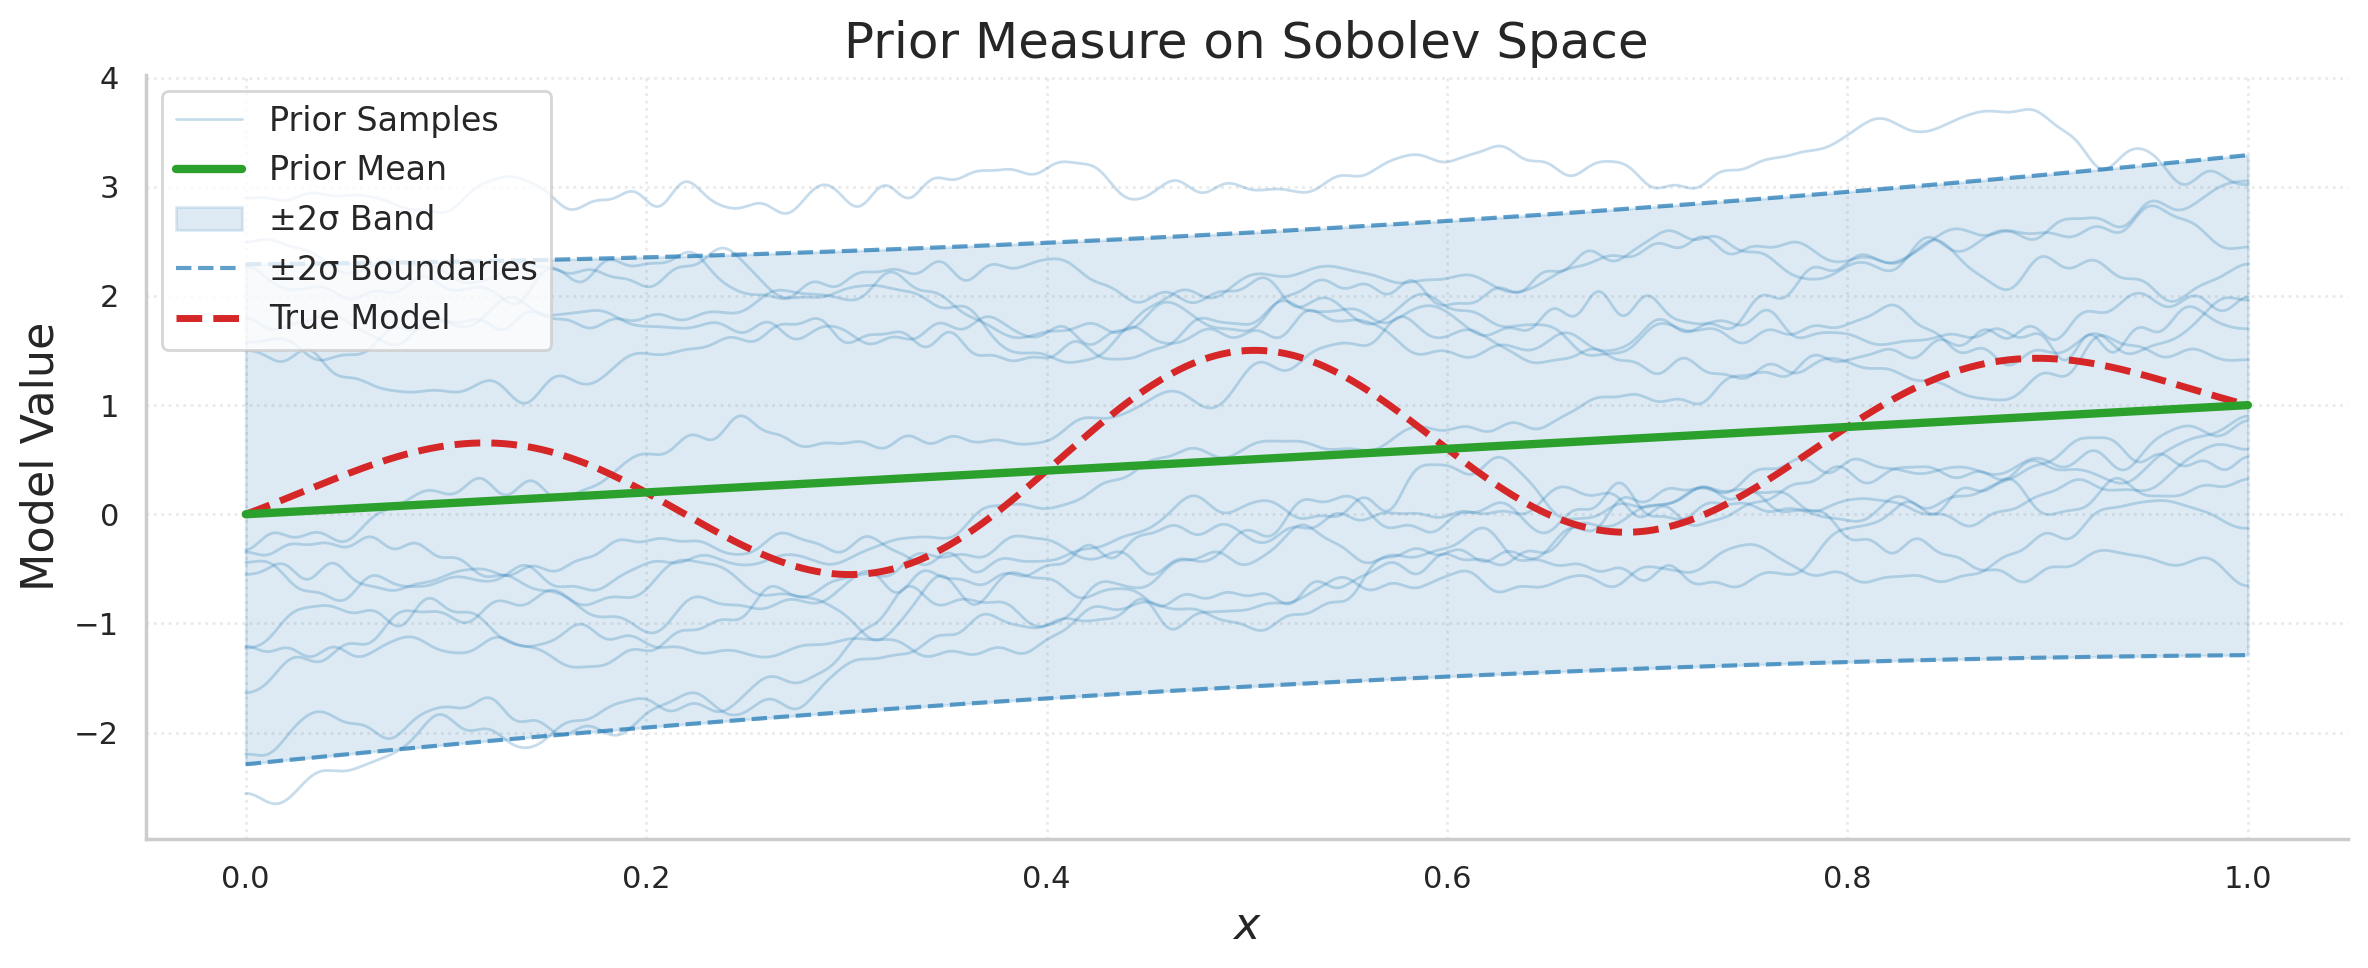

In [13]:
# Visualize the prior measure
fig_title = "Prior Measure on Model Space (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Parameters for visualization
num_samples = 15
sample_color = 'tab:blue'
mean_color = 'tab:green'
std_color = 'tab:blue'

plt.figure(figsize=(12, 5), dpi=200)

# Plot prior samples
print("Drawing samples from prior measure...")
for i in range(num_samples):
    sample = M_prior.sample()
    plt.plot(x, sample.evaluate(x), color=sample_color, alpha=0.25, linewidth=1,
            label='Prior Samples' if i == 0 else "")

# Compute and plot uncertainty bounds
print("Computing prior uncertainty...")
std_M = M.zero
for i, eigenvalue in enumerate(C_0.get_eigenvalues(range(K))):
    eigenfunction = C_0.get_eigenfunction(i)
    std_M += eigenvalue * eigenfunction * eigenfunction
std_values = np.sqrt(std_M.evaluate(x))

# Plot prior mean and uncertainty
mean_values = M_prior.expectation.evaluate(x)
plt.plot(x, mean_values, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
plt.fill_between(x, mean_values - 2*std_values, mean_values + 2*std_values,
                 color=std_color, alpha=0.15, label='±2σ Band')
plt.plot(x, mean_values + 2*std_values, color=std_color, linestyle='--',
        alpha=0.7, linewidth=1.5, label='±2σ Boundaries')
plt.plot(x, mean_values - 2*std_values, color=std_color, linestyle='--',
        alpha=0.7, linewidth=1.5)

# Plot true model
plt.plot(x, m_bar.evaluate(x), color='tab:red', linewidth=2.5,
        label='True Model', linestyle='--', zorder=9)

plt.title("Prior Measure on Sobolev Space", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## Property Prior Analysis

### Push-forward of Model Prior

The property prior is obtained by pushing the model prior through the target operator:
$$\mu_{\mathcal{P}}^0 = \mathcal{T}_* \mu_{\mathcal{M}}^0 = \mathcal{N}(\mathcal{T}(m_0), \mathcal{T} C_0 \mathcal{T}^*)$$

This gives us prior beliefs about the local properties before incorporating data.

In [14]:
# Compute property prior by pushing model prior through target operator
print("Computing property prior measure...")
prior_P = M_prior.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True, galerkin=True, parallel=True, n_jobs=8)))

print(f"Property prior computed for {N_p} target locations")
print(f"Property uncertainty range: [{std_P.min():.3f}, {std_P.max():.3f}]")

Computing property prior measure...
Property prior computed for 20 target locations
Property uncertainty range: [1.004, 1.027]
Property prior computed for 20 target locations
Property uncertainty range: [1.004, 1.027]


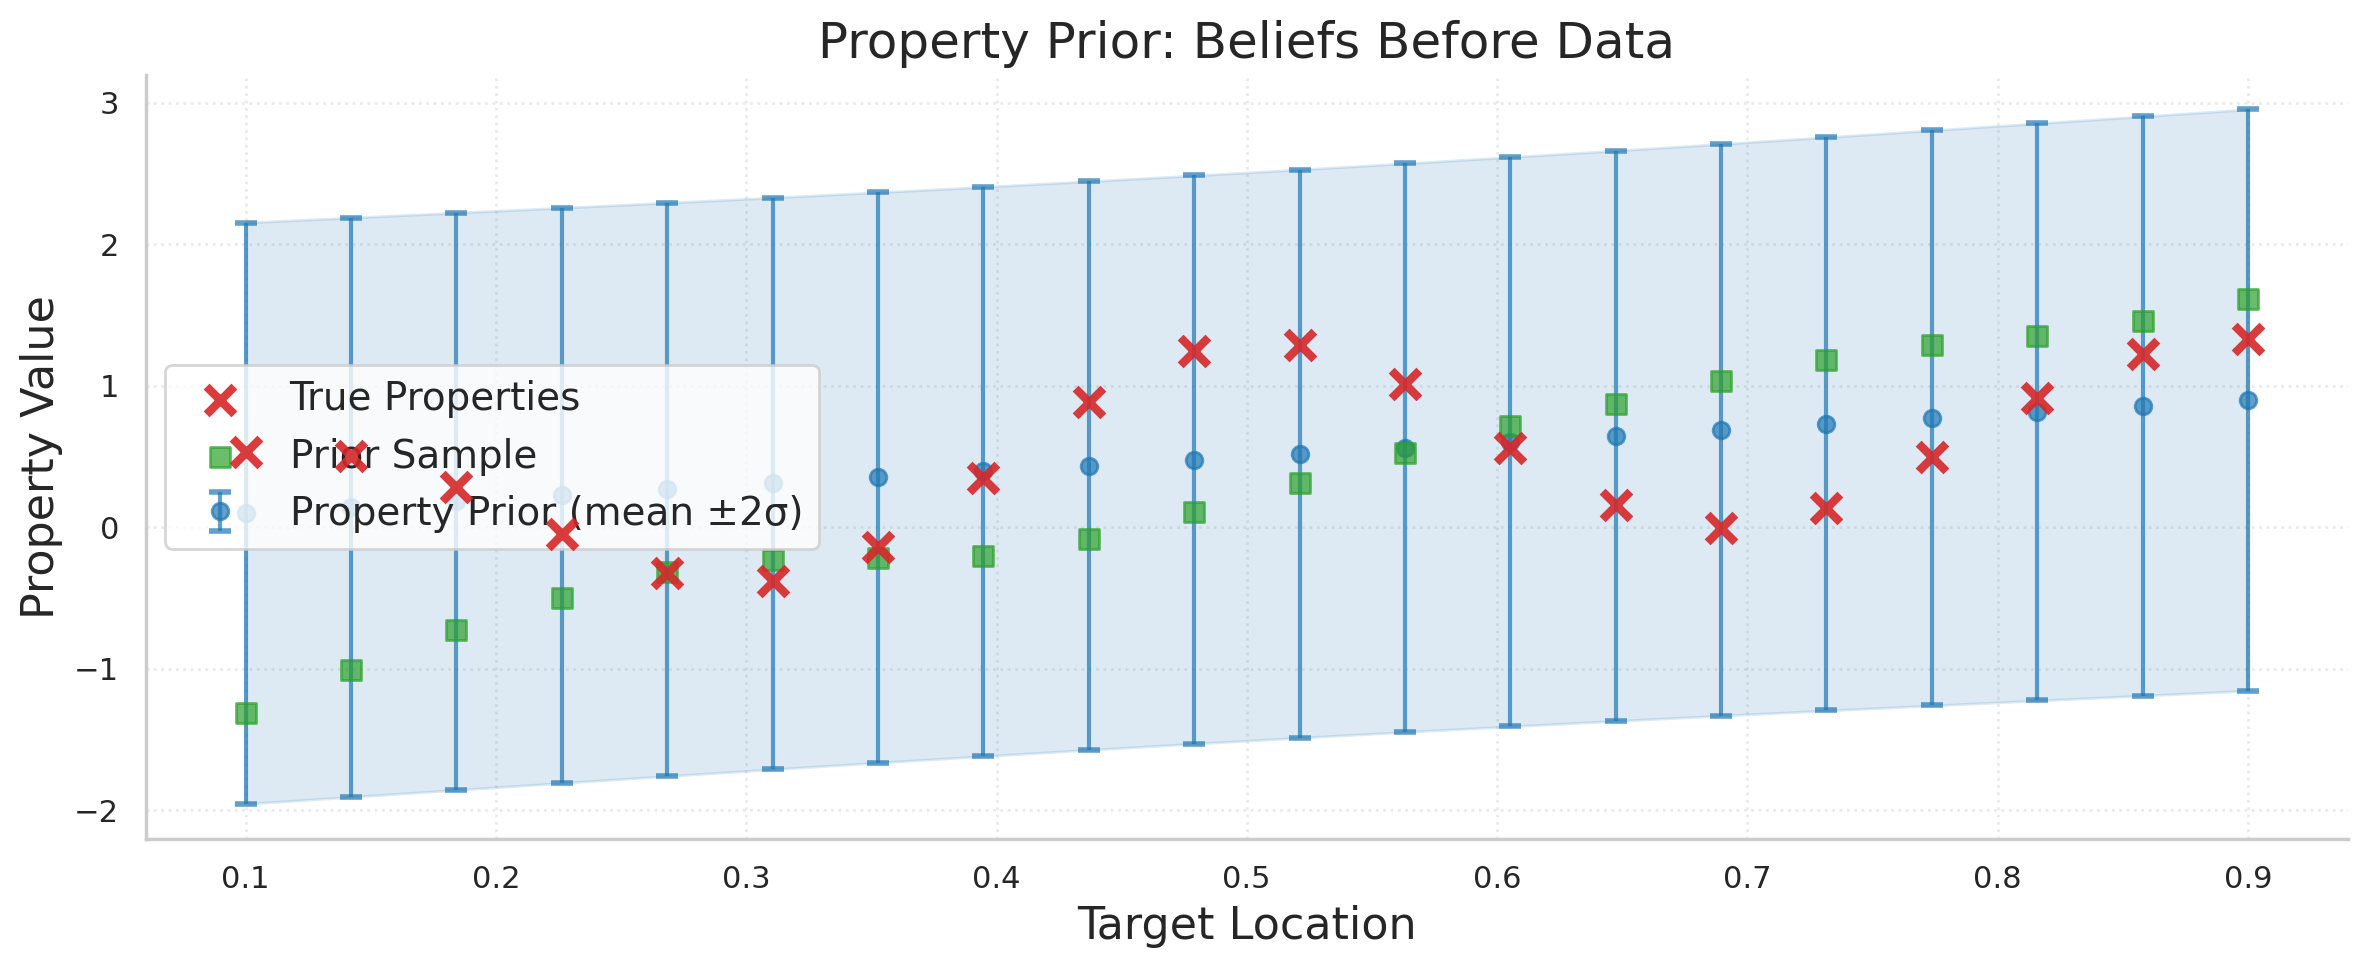

True properties range: [-0.381, 1.332]
How many true properties are within prior ±2σ: 20/20


In [15]:
# Visualize property prior
fig_title = "Property Prior Distribution (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Property prior mean and uncertainty
mean_prop = T(M_prior.expectation)
plt.errorbar(centers, mean_prop, yerr=2*std_P, fmt='o', color='tab:blue',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Prior (mean ±2σ)')
plt.fill_between(centers, mean_prop - 2*std_P, mean_prop + 2*std_P,
                color='tab:blue', alpha=0.15)

# True property values
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=100, alpha=0.9, linewidths=3, zorder=10)

# Sample from property prior
sampled_props = prior_P.sample()
plt.scatter(centers, sampled_props, label='Prior Sample',
           color='tab:green', marker='s', s=50, alpha=0.7, zorder=5)

plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Prior: Beliefs Before Data', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print some statistics
print(f"True properties range: [{true_props.min():.3f}, {true_props.max():.3f}]")
print(f"How many true properties are within prior ±2σ: {np.sum(np.abs(true_props - mean_prop) <= 2*std_P)}/{len(true_props)}")

## Bayesian Update: Computing the Posterior

### Model Posterior

The Bayesian update combines prior beliefs with data likelihood to give the posterior:
$$\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$$

where:
- **Posterior covariance**: $C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}$
- **Posterior mean**: $\tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1} m_0)$

This represents our updated beliefs about the model after incorporating the data.

In [16]:
# Bayesian inference setup and posterior computation
import time

print("="*80)
print("BAYESIAN INFERENCE")
print("="*80)

# Common setup
t0 = time.time()
print("\nSetting up Bayesian inference...")
forward_problem = LinearForwardProblem(G, data_error_measure=gaussian_D_noise)
bayesian_inference = LinearBayesianInference(forward_problem, M_prior, T)
solver = CholeskySolver(parallel=True, n_jobs=8)
t1 = time.time()
print(f"   Setup time: {t1-t0:.3f}s")

if COMPUTE_MODEL_POSTERIOR:
    print("\n" + "="*80)
    print("WORKFLOW 1: Model Posterior → Property Posterior")
    print("="*80)

    # Compute model posterior
    print("\n1. Computing model posterior measure...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Extract dense matrix
    print("\n2. Extracting dense covariance matrix...")
    t4 = time.time()
    C_M_matrix = posterior_model.covariance.matrix(dense=True, parallel=True, n_jobs=8)
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Create sampling-capable measure
    print("\n3. Creating sampling-capable measure...")
    t6 = time.time()
    mu_M = GaussianMeasure.from_covariance_matrix(M, C_M_matrix, expectation=posterior_model.expectation)
    m_tilde = mu_M.expectation
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    # Compute property posterior by pushing model posterior
    print("\n4. Computing property posterior (via model)...")
    t8 = time.time()
    property_posterior = mu_M.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=8)
    t9 = time.time()
    print(f"   Time: {t9-t8:.3f}s")

    total_time = t9 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 1 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Dense matrix:      {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Measure creation:  {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print(f"  Property posterior:{(t9-t8)/total_time*100:5.1f}%  ({t9-t8:.3f}s)")

else:
    print("\n" + "="*80)
    print("WORKFLOW 2: Property Posterior Directly (Skip Model)")
    print("="*80)

    # Compute model posterior mean only (no dense covariance)
    print("\n1. Computing model posterior (mean only)...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    m_tilde = posterior_model.expectation
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Push to property space (fast - no dense matrices involved)
    print("\n2. Computing property posterior...")
    t4 = time.time()
    property_posterior = posterior_model.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Extract only the small property covariance matrix
    print("\n3. Extracting property covariance...")
    t6 = time.time()
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=8)
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    total_time = t7 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 2 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Push to property:  {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Property cov:      {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print("\n💡 Skipped expensive dense model covariance extraction!")

print(f"{'='*80}")

# Data fit (works for both workflows)
data_misfit = np.linalg.norm(G(m_tilde) - d_tilde)
print(f"\nData misfit (posterior): {data_misfit:.4f}")
print(f"Data misfit (prior):     {np.linalg.norm(G(m_0) - d_tilde):.4f}")

# Show improvement
relative_improvement = 1 - data_misfit / np.linalg.norm(G(m_0) - d_tilde)
print(f"Data fit improvement: {100 * relative_improvement:.1f}%")

BAYESIAN INFERENCE

Setting up Bayesian inference...
   Setup time: 0.000s

WORKFLOW 1: Model Posterior → Property Posterior

1. Computing model posterior measure...
   Time: 1.839s

2. Extracting dense covariance matrix...
   Time: 1.839s

2. Extracting dense covariance matrix...
   Time: 5.194s

3. Creating sampling-capable measure...
   Time: 0.001s

4. Computing property posterior (via model)...
   Time: 5.194s

3. Creating sampling-capable measure...
   Time: 0.001s

4. Computing property posterior (via model)...
   Time: 0.933s

WORKFLOW 1 TOTAL TIME: 7.968s

Breakdown:
  Setup:               0.0%  (0.000s)
  Model posterior:    23.1%  (1.839s)
  Dense matrix:       65.2%  (5.194s)
  Measure creation:    0.0%  (0.001s)
  Property posterior: 11.7%  (0.933s)

Data misfit (posterior): 1.4114
Data misfit (prior):     1.6428
Data fit improvement: 14.1%
   Time: 0.933s

WORKFLOW 1 TOTAL TIME: 7.968s

Breakdown:
  Setup:               0.0%  (0.000s)
  Model posterior:    23.1%  (1.839s)

Sampling from model posterior...


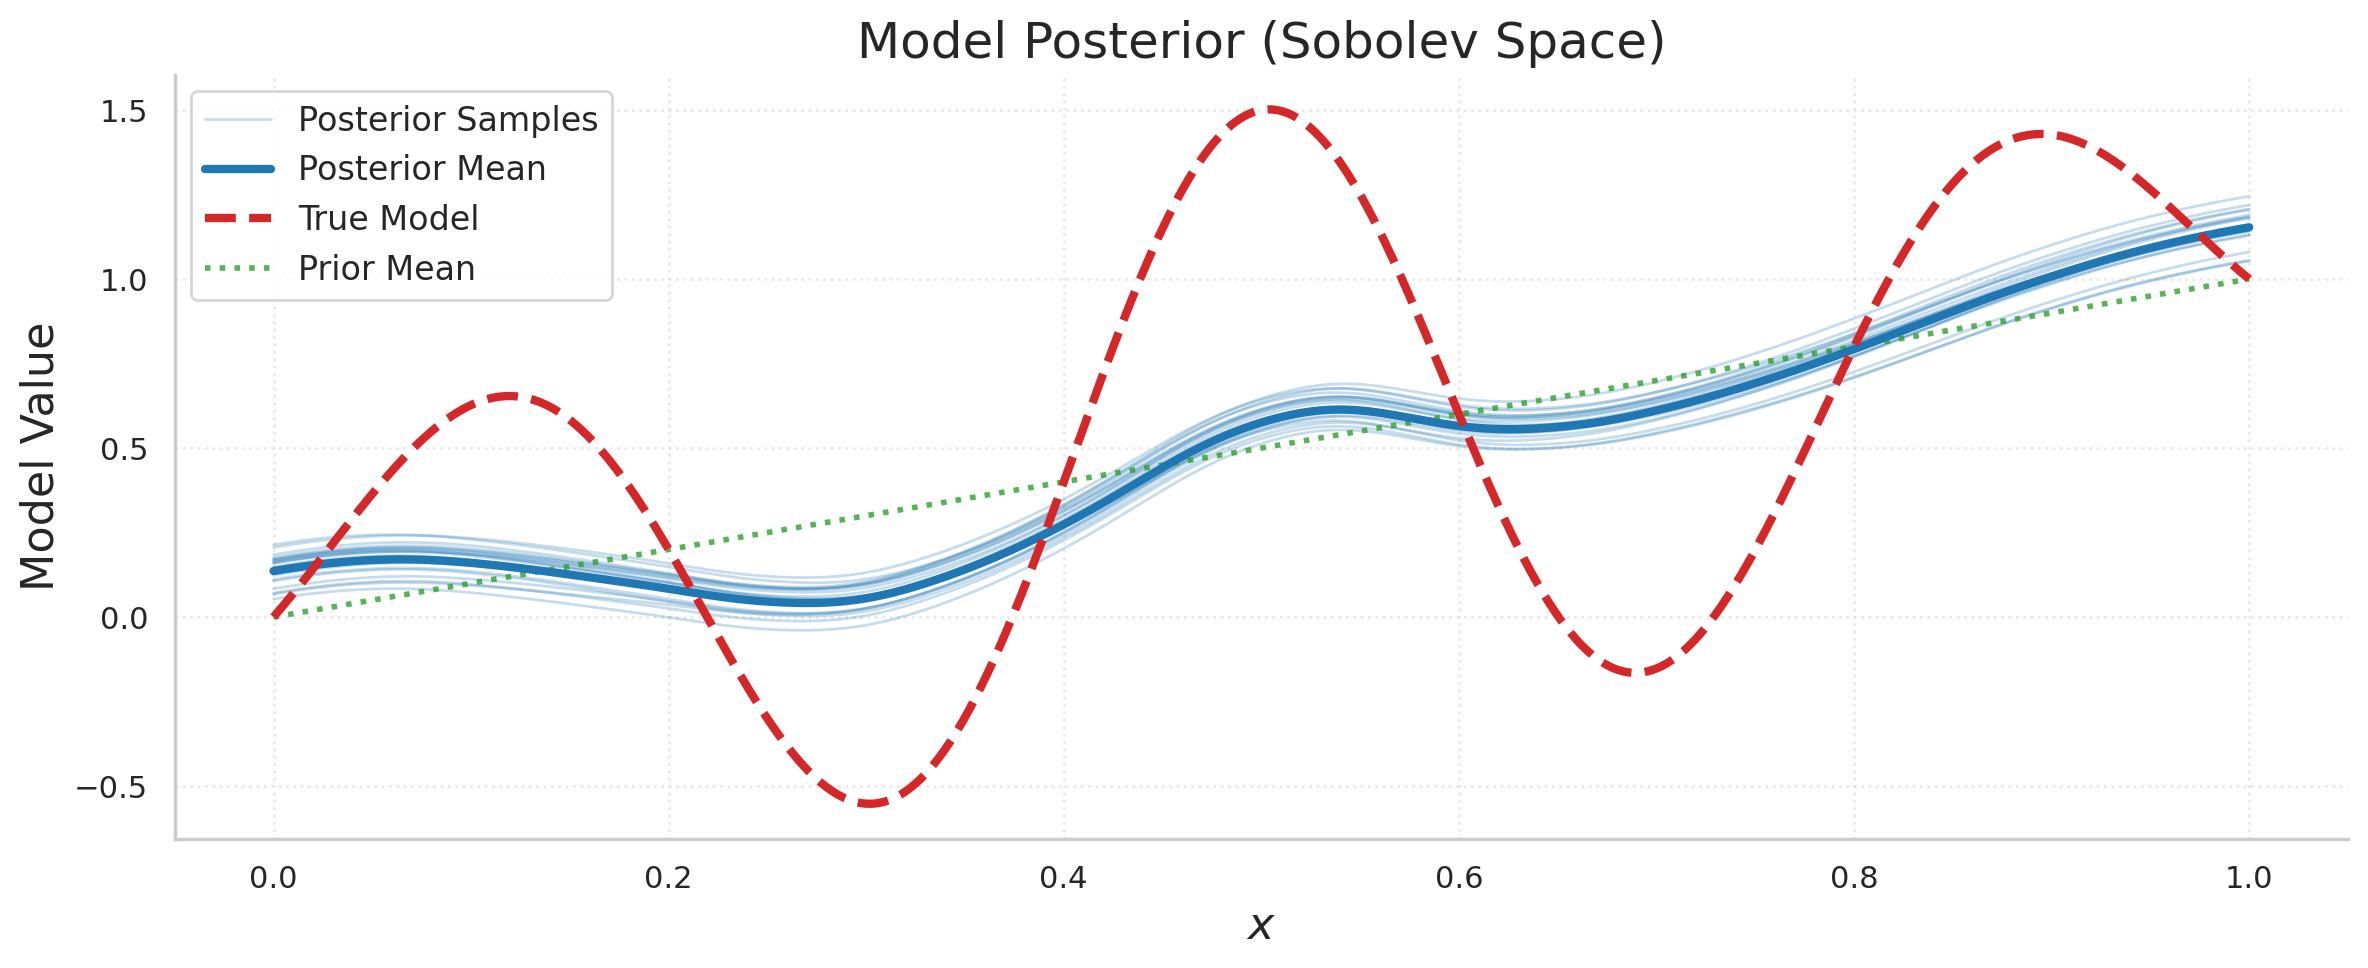

RMS reconstruction error: 0.4705
Relative error: 76.2%


In [17]:
if COMPUTE_MODEL_POSTERIOR:
    # Visualize posterior measure on model space with samples
    fig_title = "Model Posterior Distribution (Sobolev)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Plot posterior samples
    num_samples = 20
    sample_color = 'tab:blue'

    plt.figure(figsize=(12, 5), dpi=200)

    print("Sampling from model posterior...")
    for i in range(num_samples):
        sample = mu_M.sample()
        plt.plot(x, sample.evaluate(x), color=sample_color, alpha=0.25, linewidth=1,
                label='Posterior Samples' if i == 0 else "")

    # Plot posterior mean, true model, and prior mean
    plt.plot(x, m_tilde.evaluate(x), color='tab:blue', linewidth=3,
            label='Posterior Mean', zorder=10)
    plt.plot(x, m_bar.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
            label='True Model', zorder=10)
    plt.plot(x, M_prior.expectation.evaluate(x), color='tab:green',
            linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    plt.title("Model Posterior (Sobolev Space)", fontsize=18)
    plt.xlabel(r"$x$", fontsize=16)
    plt.ylabel("Model Value", fontsize=16)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.4)
    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error
    reconstruction_error = np.sqrt(np.mean((m_tilde.evaluate(x) - m_bar.evaluate(x))**2))
    print(f"RMS reconstruction error: {reconstruction_error:.4f}")
    print(f"Relative error: {100 * reconstruction_error / np.std(m_bar.evaluate(x)):.1f}%")

else:
    # Visualize posterior mean only (no samples, no dense covariance)
    fig_title = "Model Posterior Mean (Sobolev)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    plt.figure(figsize=(12, 5), dpi=200)

    # Plot posterior mean, true model, and prior mean
    plt.plot(x, m_tilde.evaluate(x), color='tab:blue', linewidth=3,
            label='Posterior Mean', zorder=10)
    plt.plot(x, m_bar.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
            label='True Model', zorder=10)
    plt.plot(x, M_prior.expectation.evaluate(x), color='tab:green',
            linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    plt.title("Model Posterior Mean (Sobolev Space, Fast Workflow)", fontsize=18)
    plt.xlabel(r"$x$", fontsize=16)
    plt.ylabel("Model Value", fontsize=16)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.4)
    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error
    reconstruction_error = np.sqrt(np.mean((m_tilde.evaluate(x) - m_bar.evaluate(x))**2))
    print(f"RMS reconstruction error: {reconstruction_error:.4f}")
    print(f"Relative error: {100 * reconstruction_error / np.std(m_bar.evaluate(x)):.1f}%")
    print("\n💡 Note: Skipped sampling (no dense model covariance computed)")

### Property Posterior 

We can directly compute the property posterior without explicitly constructing the full model posterior:
$$\mu_{\mathcal{P}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$$

where:
- **Property mean**: $\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m})$ 
- **Property covariance**: $\mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*$

This represents our final inferences about the local properties of interest.

In [18]:
# Property posterior already computed in main inference cell
# Just verify variables exist

if 'p_tilde' not in locals() or 'cov_P_matrix' not in locals():
    raise RuntimeError("Property posterior not computed - run inference cell above first")

print(f"✓ Property posterior available")
print(f"  Property mean computed for {len(p_tilde)} locations")
print(f"  Property covariance matrix size: {cov_P_matrix.shape}")

✓ Property posterior available
  Property mean computed for 20 locations
  Property covariance matrix size: (20, 20)


In [19]:
# Create sampling-capable property posterior measure
gaussian_P = GaussianMeasure.from_covariance_matrix(P, cov_P_matrix, expectation=p_tilde)
print("Property posterior Gaussian measure created successfully")

Property posterior Gaussian measure created successfully


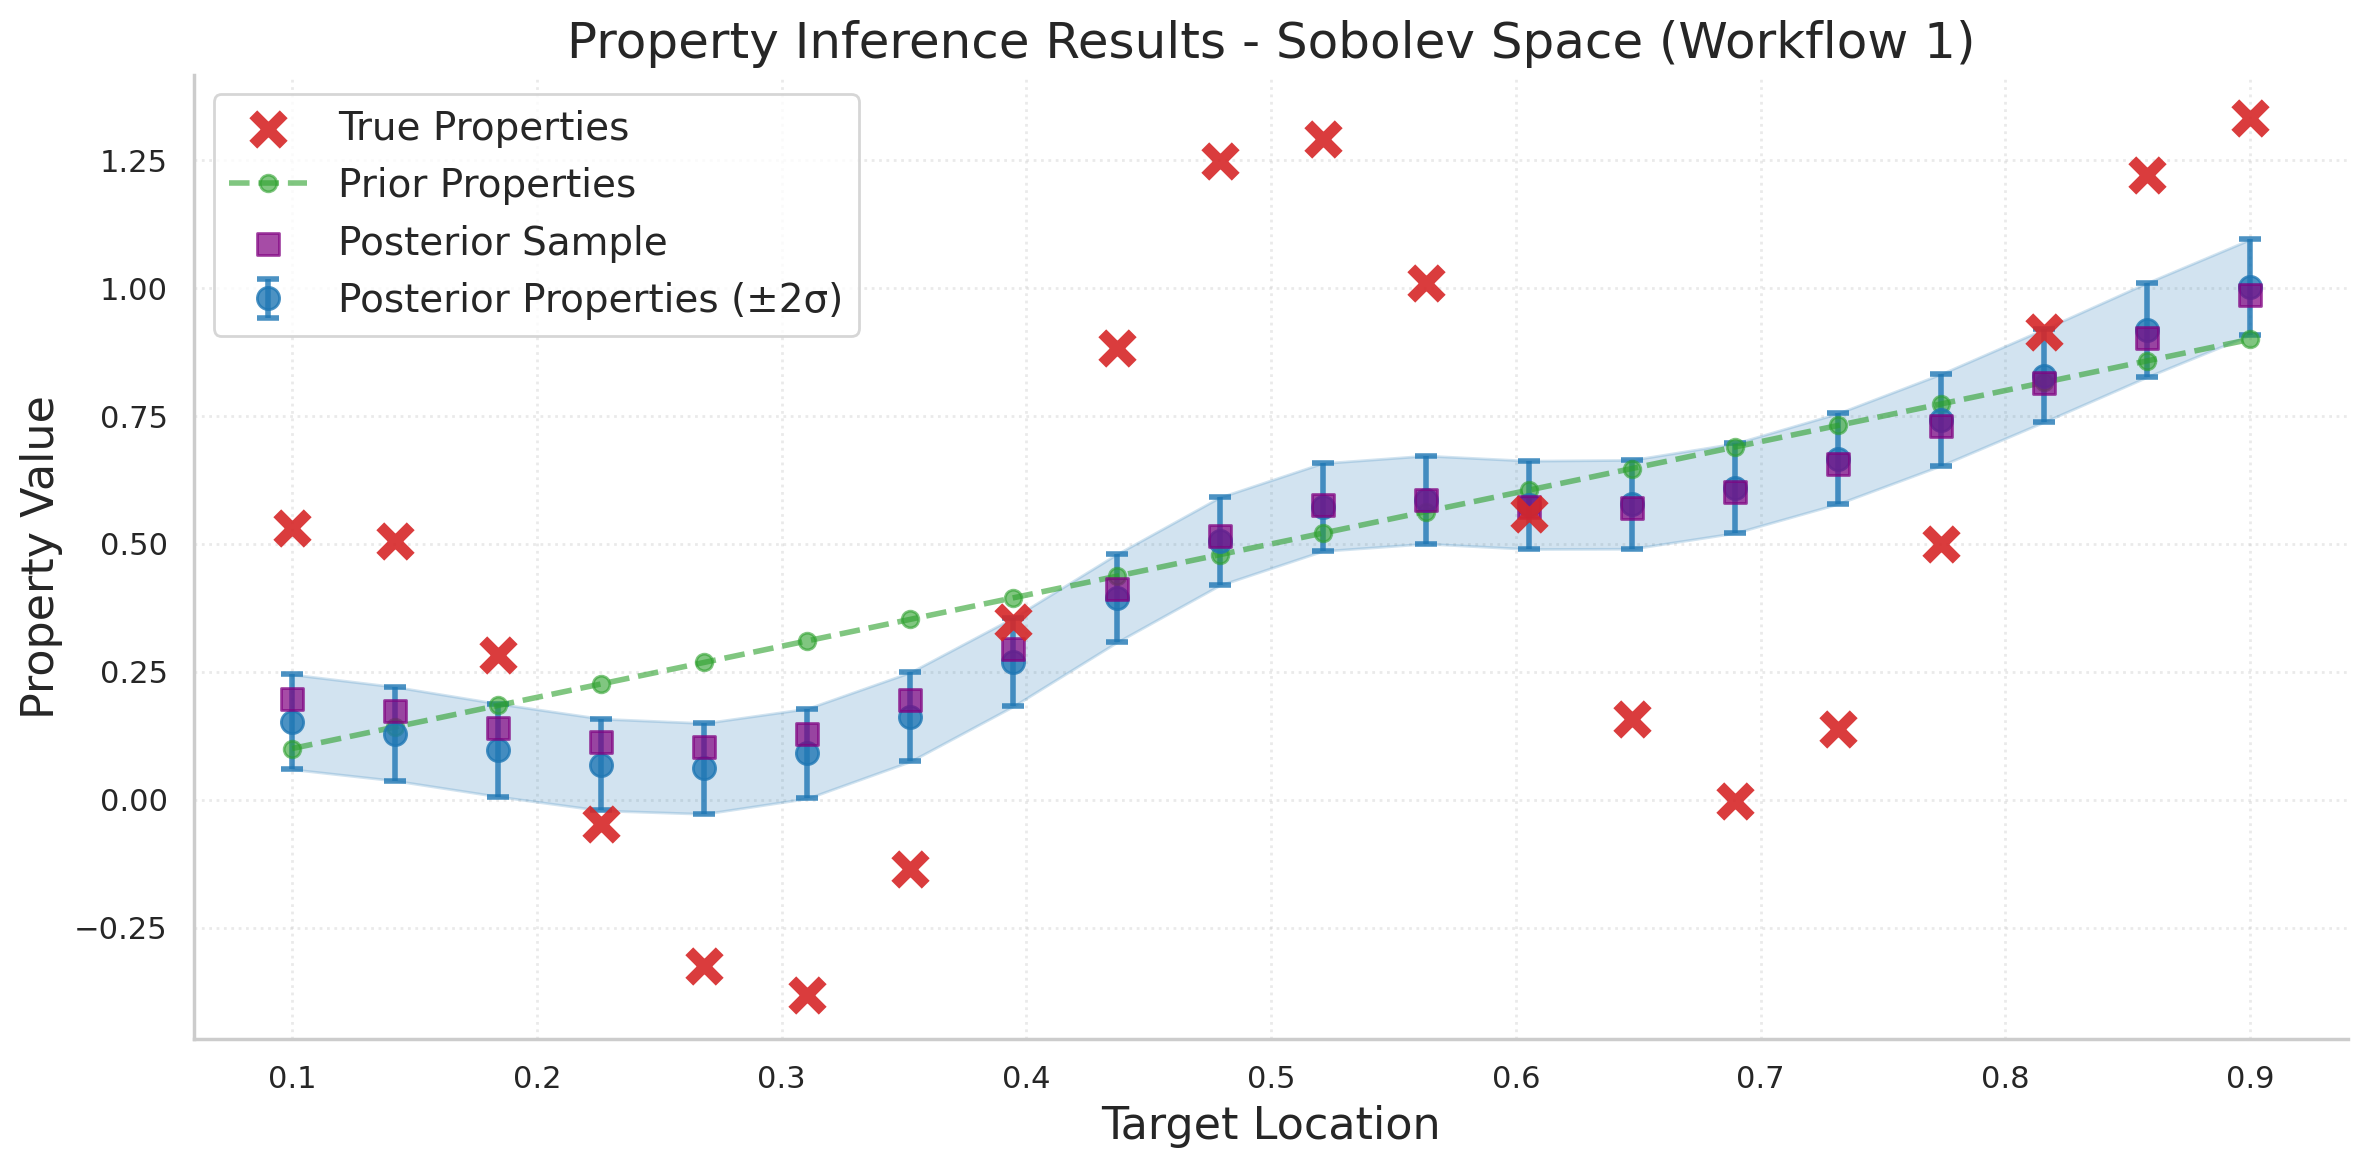


FINAL RESULTS SUMMARY
Workflow: 1 (via model posterior)
Properties successfully inferred: 3/20 (15.0%)
Mean absolute error: 0.3606
RMS error: 0.4116
Max error: 0.7435
Average uncertainty reduction: 95.6%


In [20]:
# Final property inference results
std_P_post = np.sqrt(np.diag(cov_P_matrix))

fig_title = "Property Inference Results (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Property posterior with uncertainty
plt.errorbar(centers, p_tilde, yerr=2*std_P_post, fmt='o', color='tab:blue',
            alpha=0.8, capsize=4, capthick=2, markersize=8, linewidth=2,
            label='Posterior Properties (±2σ)')
plt.fill_between(centers, p_tilde - 2*std_P_post, p_tilde + 2*std_P_post,
                color='tab:blue', alpha=0.2)

# True properties
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)

# Prior for comparison
mean_prop_prior = T(M_prior.expectation)
plt.plot(centers, mean_prop_prior, 'o--', color='tab:green', alpha=0.6,
        markersize=6, linewidth=2, label='Prior Properties')

# Sample from posterior (only if we have full covariance)
if COMPUTE_MODEL_POSTERIOR:
    sampled_props_post = gaussian_P.sample()
    plt.scatter(centers, sampled_props_post, label='Posterior Sample',
               color='purple', marker='s', s=60, alpha=0.7, zorder=5)

workflow_label = "Workflow 1" if COMPUTE_MODEL_POSTERIOR else "Workflow 2 (Fast)"
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title(f'Property Inference Results - Sobolev Space ({workflow_label})', fontsize=18)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment
property_errors = np.abs(p_tilde - true_props)
within_2sigma = np.sum(property_errors <= 2*std_P_post)

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Workflow: {'1 (via model posterior)' if COMPUTE_MODEL_POSTERIOR else '2 (direct - fast)'}")
print(f"Properties successfully inferred: {within_2sigma}/{len(true_props)} ({100*within_2sigma/len(true_props):.1f}%)")
print(f"Mean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty reduction: {100*(1 - np.mean(std_P_post)/np.mean(std_P)):.1f}%")
print("="*50)

## Performance Notes

### Two Workflows Compared

This notebook supports two computational workflows controlled by `COMPUTE_MODEL_POSTERIOR`:

#### Workflow 1: Model Posterior → Property Posterior (Slower but Complete)
Set `COMPUTE_MODEL_POSTERIOR = True`

**Steps:**
1. Compute model posterior measure
2. Extract dense N×N model covariance matrix (⚠️ expensive!)
3. Create sampling-capable model measure
4. Push to property space via $\mathcal{T}$
5. Extract property covariance

**Advantages:**
- Can sample from model posterior
- Full model posterior visualization with uncertainty bands

**Disadvantages:**
- Slow: ~60-90 seconds for typical parameters
- Memory intensive: O(N²) dense matrix

#### Workflow 2: Property Posterior Directly (Faster, Properties Only)
Set `COMPUTE_MODEL_POSTERIOR = False`

**Steps:**
1. Compute property posterior measure directly
2. Extract small N_p×N_p property covariance (fast!)
3. Compute model posterior mean only (no covariance)

**Advantages:**
- Fast: ~15-20 seconds for typical parameters
- Memory efficient: only O(N_p²) where N_p << N
- Identical property posterior results

**Disadvantages:**
- Cannot sample from model posterior
- Model space visualization shows mean only

### Speedup Analysis

For typical parameters (N~100 DOFs, N_p=20):
- **Workflow 1**: ~60-90 seconds
- **Workflow 2**: ~15-20 seconds  
- **Speedup**: ~4x

The bottleneck in Workflow 1 is extracting the dense model covariance matrix, which requires O(N²) operator applications.

### Recommendation

**Use Workflow 2** (`COMPUTE_MODEL_POSTERIOR = False`) when:
- You only care about property inference (most applications!)
- Speed matters
- Memory is limited

**Use Workflow 1** (`COMPUTE_MODEL_POSTERIOR = True`) when:
- You need samples from the model posterior
- You want full model space uncertainty visualization
- You're computing multiple different property posteriors from the same model posterior